# <font color='Green'> Example G-MODE KPFM Notebook </font>
## <font color='Green'>SPMonSPM August 2018 (Leuven, Belgium)</font>

### <font color='Black'>Author: Liam Collins</font>
### <font color='Black'>Oak Ridge National Laboratory</font>
#### <font color='Black'>Contributions to this notebook were made by Anugra Saxena, Raj Giridharagopal and Chris Smith</font>

This notebook can be used to analyze G-KPFM data. The goal is to realize a time resolved KPFM measurement by direct recovery of the electrostatic foce directly from the photodetector response. Detailed Information on the data collection and background theory can be found in Collins et al. ([DOI: 10.1021/acsnano.7b02114](http://pubs.acs.org/doi/abs/10.1021/acsnano.7b02114))
<br>

**The work flow is comprised as follows:**<br>

(1a) Translation of G-Tune data to H5 <br>
(1b) Fitting Tune data to Simple Harmonic Oscillator model<br>

(2a) Translation of Image data to H5<br>
(2b) Denoising by Fourier Filtering<br>
(2b) Denoising by Principle Component Analysis<br>

(3a) Fast Free Force Recovery Procedure<br>
(3b) Fitting to extract CPD and C'<br>

(4a) Spectral Unmixing and Clustering<br></font>

## Load All Necessary Packages

First, we need to load the necessary packages.

In [1]:
# Import necessary libraries:

# Ensure that this code works on both python 2 and python 3
from __future__ import division, print_function, absolute_import, unicode_literals


# Visualization:
import matplotlib.pyplot as plt
from IPython.display import display, HTML
from scipy.signal import butter, filtfilt,correlate
from scipy.io import loadmat
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib.cm as cm

# for downloading files:
import wget
import os

# General utilities:
import sys
from warnings import warn
import h5py
from functools import partial

# multivariate analysis:
from sklearn.cluster import KMeans
from sklearn.decomposition import NMF, FastICA
import subprocess

# Computation:
import numpy as np
import numpy.polynomial.polynomial as npPoly
from scipy.optimize import curve_fit

#sys.path.append('/home/challtdow/workspace/pyUSID')
#sys.path.append('/home/challtdow/workspace/pycroscopy')
def install(package):
    subprocess.call([sys.executable, "-m", "pip", "install", package])
    
try:
    import pyUSID as usid
except ImportError:
    print('pyUSID not found.  Will install with pip.')
    import pip
    install('pyUSID')
    import pyUSID as usid

try:
    import pycroscopy as px
except ImportError:
    print('pycroscopy not found.  Will install with pip.')
    import pip
    install('pycroscopy')
    import pycroscopy as px

    
#from usid.plot_utils import set_tick_font_size, plot_curves, plot_map_stack

C:\Users\lz1\AppData\Local\Continuum\anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
# set up notebook to show plots within the notebook and allow for interactive plotting
% matplotlib notebook
% precision %.4g

'%.4g'

## Setting up Notebook
**You can change options below depending on what analysis you want to perform**

In [3]:
##################################################################
##Output file determines where images are saved to
##Create the directory if it doesn't exist
################################################################

current_path = os.getcwd()
output_filepath = os.path.join(current_path, "ImageData") 
if not os.path.exists(output_filepath):
    os.mkdir(output_filepath)

################################################################
###Here you can decide what analysis to perform
################################################################

save_figure = True # Print plots as .tif figures

Filter_data= True   # Set this to true if you want to Fourier filter data

DO_F3R = False   # Set this to true if you want to do F3R recovery or just load data from file

do_SVD_denoise= True   # Set this to true if you want to PCA denoise your data

do_para_fit= False # Set this to true if you want to do parabolic fitting

do_SVD_CPD= True   # Set this to true if you want to do PCA of CPD results

do_Kmeans=True # Set this to true if you want to do Kmeans CPD results

##################################################################
## Number of cores available for parallel processing
################################################################

num_cores=2

#These are the dimensions of you image data in microns
img_length = 80e-6
img_height = 40e-6



## Step 1) Model the Cantilever Transfer Function

We need to describe our cantilever in terms of its SHO parameters. To do this I perform a calibration of the frequency response of the cantilever



#### Step 1a. Go fetch the data


In [4]:
#tune_file_path = wget.download('https://ftp.ornl.gov/ftp_out/uP142oLfqNYj/GFA0_tune_0012.h5')
tune_file_path = wget.download('https://www.dropbox.com/s/3v6bxwkjofbr8xo/GFA0_tune_0012.h5?dl=1')
#tune_file_path='C:/Users/lz1/Desktop/SPMonSPM Notebook/New folder/GFA0_tune_0012.h5'

h5_tune_file = h5py.File(tune_file_path, 'r+')
usid.hdf_utils.print_tree(h5_tune_file)


100% [..................................................] 218221696 / 218221696/
├ Measurement_000
  ---------------
  ├ Channel_000
    -----------
    ├ Raw_Data
  ├ Channel_001
    -----------
    ├ Raw_Data
  ├ Position_Indices
  ├ Position_Values
  ├ Spectroscopic_Indices
  ├ Spectroscopic_Values
  ├ Tune_Function_000
    -----------------
    ├ Position_Indices
    ├ Position_Values
    ├ Spectroscopic_Indices
    ├ Spectroscopic_Values
    ├ Tune_Data
  ├ Tune_Function_001
    -----------------
    ├ Position_Indices
    ├ Position_Values
    ├ Spectroscopic_Indices
    ├ Spectroscopic_Values
    ├ Tune_Data
  ├ Tune_Function_002
    -----------------
    ├ Position_Indices
    ├ Position_Values
    ├ Spectroscopic_Indices
    ├ Spectroscopic_Values
    ├ Tune_Data


#### Step 1b. Extract the Resonance Modes and Fit to a simple harmonic oscillator model

In [5]:
# You should put this and the following cell into a process class 


##############################################################
##Step 1b. Extract the Resonance Modes Considered in the Force Reconstruction
##############################################################

#define number of eigenmodes to consider
num_bandsVal=2

#define bands (center frequency +/- bandwith)
w_center1 = 70E3
bandwidth1 = 10E3
w_center2 = 480E3
bandwidth2 = 20E3

MB0_w1 = w_center1 - bandwidth1
MB0_w2 = w_center1 + bandwidth1
MB1_w1 = w_center2 - bandwidth2
MB1_w2 = w_center2 + bandwidth2

MB1_amp = 30E-9
MB2_amp = 1E-9

MB_parm_vec = np.array([MB1_amp,MB0_w1,MB0_w2,MB1_amp,MB1_w1,MB1_w2]).reshape(2,3)
band_edge_mat = MB_parm_vec[:,1:3]

h5_tune_resp = px.hdf_utils.find_dataset(h5_tune_file, 'Raw_Data')[0]
h5_tune = px.hdf_utils.find_dataset(h5_tune_file, 'Raw_Data')[-1]

# Fetch some important parameters
samp_rate = (px.hdf_utils.get_attr(h5_tune.parent.parent, 'IO_rate_[Hz]'))
num_rows=h5_tune.pos_dim_sizes[0]
N_points_per_line=h5_tune.spec_dim_sizes[0]
N_points_per_pixel=N_points_per_line / num_rows
w_vec2 = np.linspace(-0.5 * samp_rate, 0.5 * samp_rate - 1.0*samp_rate / N_points_per_line, N_points_per_line)
dt = 1/samp_rate
df = 1/dt

# Response
A_pd = np.mean(h5_tune_resp, axis=0)
yt0_tune = A_pd - np.mean(A_pd)
Yt0_tune = np.fft.fftshift(np.fft.fft(yt0_tune,N_points_per_line)*dt)

# Excitation
h5_spec_vals = px.hdf_utils.get_auxiliary_datasets(h5_tune, aux_dset_name='Spectroscopic_Values')[0]
BE_pd = h5_spec_vals[0, :]

f0 = BE_pd - np.mean(BE_pd)
F0 = np.fft.fftshift(np.fft.fft(f0,N_points_per_line)*dt)
excited_bin_ind = np.where(np.abs(F0)>0.5e-3)

# Divide response by drive to get transfer function
TF_vec = Yt0_tune/F0


# Plot response and fits
plt.figure(2)
plt.subplot(2,1,1)
plt.semilogy(np.abs(w_vec2[excited_bin_ind])*1E-6,np.abs(TF_vec[excited_bin_ind]))
plt.tick_params(labelsize=14)
plt.xlabel('Frequency (MHz)',fontsize=16)
plt.ylabel('Amplitude (a.u.)',fontsize=16)
plt.tight_layout(pad=1.0, w_pad=1.0, h_pad=1.0)
plt.subplot(2,1,2)
plt.semilogy(np.abs(w_vec2[excited_bin_ind])*1E-6,np.angle(TF_vec[excited_bin_ind]))
plt.tick_params(labelsize=14)
plt.xlabel('Frequency (MHz)',fontsize=16)
plt.ylabel('Phase (Rad)',fontsize=16)
plt.tight_layout(pad=1.0, w_pad=1.0, h_pad=1.0)

C:\Users\lz1\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:54: RuntimeWarning: divide by zero encountered in true_divide


<IPython.core.display.Javascript object>

In [6]:
##############################################################
##Construct an effective Transfer function (TF_Norm) from SHO fits
##############################################################

TunePhase = -np.pi
num_bands = band_edge_mat.shape[0]
coef_mat = np.zeros((num_bands,4))
coef_guess_vec = np.zeros((4))
TF_fit_vec = np.zeros((w_vec2.shape))
TFb_vec = TF_vec[excited_bin_ind]
wb = w_vec2[excited_bin_ind]


for k1 in range(num_bandsVal):
    # locate the fitting region
    w1 = band_edge_mat[k1][0]
    w2 = band_edge_mat[k1][1]
    bin_ind1 = np.where(np.abs(w1-wb) == np.min(np.abs(w1-wb)))[0][0]
    bin_ind2 = np.where(np.abs(w2-wb) == np.min(np.abs(w2-wb)))[0][0]
    response_vec = TFb_vec[bin_ind1:bin_ind2+1].T
    wbb = wb[bin_ind1:bin_ind2+1].T/1E+6

    if k1 == 0:
        Q_guess = 300
    elif k1 == 1:
        Q_guess = 500
    else:
        Q_guess = 700

    response_mat = np.array([np.real(response_vec), np.imag(response_vec)]).T
    A_max_ind = np.argmax(np.abs(response_vec))
    A_max = response_vec[A_max_ind]
    A_guess = A_max/Q_guess
    wo_guess = wbb[A_max_ind]

    if k1 == 0:
        phi_guess = TunePhase

    coef_guess_vec = [np.real(A_guess), 
                      wo_guess, 
                      Q_guess, 
                      phi_guess]

    LL_vec = [0,w1/1E+6,1,np.pi] # lower limit
    UL_vec = [float("inf"),w2/1E+6,10000,-np.pi] # upper limit

    coef_vec = px.analysis.utils.be_sho.SHOestimateGuess(response_vec,wbb,10)

    response_guess_vec = px.analysis.utils.be_sho.SHOfunc(coef_guess_vec,wbb)
    response_fit_vec = px.analysis.utils.be_sho.SHOfunc(coef_vec,wbb)

    coef_vec[1] = coef_vec[1]*1E6
    coef_mat[k1,:] = coef_vec

    response_fit_full_vec = px.analysis.utils.be_sho.SHOfunc(coef_vec,w_vec2)

    TF_fit_vec = TF_fit_vec + response_fit_full_vec # check for length and dimension


    plt.figure(10, figsize=(12, 4))
    plt.subplot(1, 4, k1+1)
    plt.plot(wbb,np.abs(response_vec),'.-')
    plt.plot(wbb,np.abs(response_guess_vec),c='g')
    plt.plot(wbb,np.abs(response_fit_vec),c='r')
    plt.tick_params(labelsize=12)
    plt.xlabel('Frequency (MHz)', fontsize=16)
    plt.ylabel('Amplitude (nm)', fontsize=16)
    plt.subplot(1, 4, (k1+1)+2)
    plt.plot(wbb,np.angle(response_vec),'.-')
    plt.plot(wbb,np.angle(response_guess_vec),c='g')
    plt.plot(wbb,np.angle(response_fit_vec),c='r')
    plt.tick_params(labelsize=12)
    plt.xlabel('Frequency (MHz)', fontsize=16)
    plt.ylabel('Phase (Rad)', fontsize=16)
    plt.tight_layout(pad=1.0, w_pad=1.0, h_pad=1.0)

if save_figure == True:
    plt.savefig(output_filepath+'\SHOFitting.tif', format='tiff', transparent=True)

##############################################################
##Step 1d. write and save data to HDF5
##############################################################

Q = coef_mat[0,2]
TF_norm = ((TF_fit_vec - np.min(np.abs(TF_fit_vec))) / 
           np.max(np.abs(TF_fit_vec)) - np.min(np.abs(TF_fit_vec)))*Q


tf_grp = px.hdf_utils.create_indexed_group(h5_tune.parent.parent, 'Tune_Function')
tf_pos_dim = px.hdf_utils.Dimension('Single Step', 'a.u.', 1)
tf_spec_dim = px.hdf_utils.Dimension('Frequency', 'MHz', w_vec2)
h5_tf = px.hdf_utils.write_main_dataset(tf_grp, TF_norm.reshape(1, -1), 'Tune_Data', 
                                        'Response', 'a.u.', 
                                        tf_pos_dim, tf_spec_dim)
h5_tune_file.flush()

# You shouldn't close the file until you're done with it.
# Also name the two hdf files different things, i.e. h5_tune_file and h5_gline_file
h5_tune_file.close()


<IPython.core.display.Javascript object>

# Step (2) Load, Translate and Denoize the G-KPFM data 


#### Step (2a) Translate digitized photodetector signal into .H5 file format. 

In [7]:

input_file_path= wget.download('https://www.dropbox.com/s/868mi4gw1h8p8fz/GFA0_n1000mV_0003.h5?dl=1')


hdf = h5py.File(input_file_path, mode='r+')

usid.hdf_utils.print_tree(hdf)

100% [................................................] 3625803158 / 3625803158/
├ Measurement_000
  ---------------
  ├ CPD_000
    -------
    ├ CPD
    ├ CPD-Cluster_000
      ---------------
      ├ Cluster_Indices
      ├ Cluster_Values
      ├ Labels
      ├ Mean_Resp_Pos_Indices
      ├ Mean_Resp_Pos_Values
      ├ Mean_Response
    ├ CPD-Cluster_001
      ---------------
      ├ Cluster_Indices
      ├ Cluster_Values
      ├ Labels
      ├ Mean_Resp_Pos_Indices
      ├ Mean_Resp_Pos_Values
      ├ Mean_Response
    ├ CPD-SVD_000
      -----------
      ├ Position_Indices
      ├ Position_Values
      ├ S
      ├ Spectroscopic_Indices
      ├ Spectroscopic_Values
      ├ U
      ├ V
    ├ CPDExpFitting_000
      -----------------
      ├ Position_Indices
      ├ Position_Values
      ├ Spectroscopic_Indices
      ├ Spectroscopic_Values
      ├ fit_param
    ├ CPDExpFitting_001
      -----------------
      ├ Position_Indices
      ├ Position_Values
      ├ Spectroscopic_Indices


In [8]:
parm_paths= wget.download('https://www.dropbox.com/s/hlhhghv0mp7r5p8/GFA0_n1000mV_0003_all.mat?dl=1')

100% [....................................................] 66986717 / 66986717

In [10]:
parm_paths

'GFA0_n1000mV_0003_all.mat'

#### Extract some relevant parameters

In [12]:


h5_main = usid.hdf_utils.find_dataset(hdf,'Raw_Data')[0]


matread = loadmat(parm_paths, variable_names=['BE_wave_AO_0', 'BE_wave_AO_1'])
pulse_wave = np.float32(np.squeeze(matread['BE_wave_AO_1'])) 

h5_pos_vals=h5_main.h5_spec_vals 
h5_pos_inds=h5_main.h5_spec_inds
h5_spec_vals = h5_main.h5_spec_vals 
h5_spec_inds = h5_main.h5_spec_inds 

samp_rate = (usid.hdf_utils.get_attr(h5_main.parent.parent, 'IO_rate_[Hz]'))

num_rows=h5_main.pos_dim_sizes[0]
N_points_per_line=h5_main.spec_dim_sizes[0]
N_points_per_pixel=N_points_per_line / num_rows

# General parameters
parms_dict = h5_main.parent.parent.attrs
samp_rate = parms_dict['IO_rate_[Hz]']
ex_freq = parms_dict['BE_center_frequency_[Hz]']
num_rows = parms_dict['grid_num_rows']
num_cols = parms_dict['grid_num_cols']

num_pts = h5_main.shape[1]
pnts_per_pix=int(num_pts/num_cols)

# Adding image size to the parameters
parms_dict['FastScanSize'] = img_length
parms_dict['SlowScanSize'] = img_height

N_points = parms_dict['num_bins']
N_points_per_pixel = parms_dict['num_bins']
time_per_osc = (1/parms_dict['BE_center_frequency_[Hz]'])
IO_rate = parms_dict['IO_rate_[Hz]']     #sampling_rate
parms_dict['sampling_rate'] = IO_rate
pnts_per_period = IO_rate * time_per_osc #points per oscillation period
pxl_time = N_points_per_pixel/IO_rate    #seconds per pixel
num_periods = int(pxl_time/time_per_osc) #total # of periods per pixel, should be an integer

pixel_ex_wfm = np.float32(np.squeeze(matread['BE_wave_AO_0'])) 

# Excitation waveform for a single line / row of data
excit_wfm = h5_spec_vals.value

# Preparing the frequency axis:
w_vec = 1E-3*np.linspace(-0.5*samp_rate, 0.5*samp_rate - samp_rate/num_pts, num_pts)
w_vec_pix = 1E-3*np.linspace(-0.5*samp_rate, 0.5*samp_rate - samp_rate/pnts_per_pix, pnts_per_pix)

# Preparing the time axis:
t_vec_line = 1E3*np.linspace(0, num_pts/samp_rate, num_pts)
t_vec_pix = 1E3*np.linspace(0, pnts_per_pix/samp_rate, pnts_per_pix)

# Dimension objects
rows_vals = np.linspace(0, img_height, num_rows)
cols_vals = np.linspace(0, img_length, num_cols)
time_vals = t_vec_pix

# Correctly adds the ancillary datasets
pos_dims = [px.write_utils.Dimension('Cols', 'm', cols_vals),
            px.write_utils.Dimension('Rows', 'm', rows_vals)]
spec_dims = [px.write_utils.Dimension('Time', 's', time_vals)]

In [13]:
print(h5_main)

usid.hdf_utils.print_tree(hdf)

<HDF5 dataset "Raw_Data": shape (64, 2097152), type "<f2">
located at: 
	/Measurement_000/Channel_000/Raw_Data 
Data contains: 
	Deflection (V) 
Data dimensions and original shape: 
Position Dimensions: 
	Y - size: 64 
Spectroscopic Dimensions: 
	Excitation - size: 2097152
Data Type:
	float16
/
├ Measurement_000
  ---------------
  ├ CPD_000
    -------
    ├ CPD
    ├ CPD-Cluster_000
      ---------------
      ├ Cluster_Indices
      ├ Cluster_Values
      ├ Labels
      ├ Mean_Resp_Pos_Indices
      ├ Mean_Resp_Pos_Values
      ├ Mean_Response
    ├ CPD-Cluster_001
      ---------------
      ├ Cluster_Indices
      ├ Cluster_Values
      ├ Labels
      ├ Mean_Resp_Pos_Indices
      ├ Mean_Resp_Pos_Values
      ├ Mean_Response
    ├ CPD-SVD_000
      -----------
      ├ Position_Indices
      ├ Position_Values
      ├ S
      ├ Spectroscopic_Indices
      ├ Spectroscopic_Values
      ├ U
      ├ V
    ├ CPDExpFitting_000
      -----------------
      ├ Position_Indices
      ├ Posit

#### Step (2b) Fourier Filter data

* Here you can play with Filters and Noise Tresholds to find the optimal filter settings  

<IPython.core.display.Javascript object>


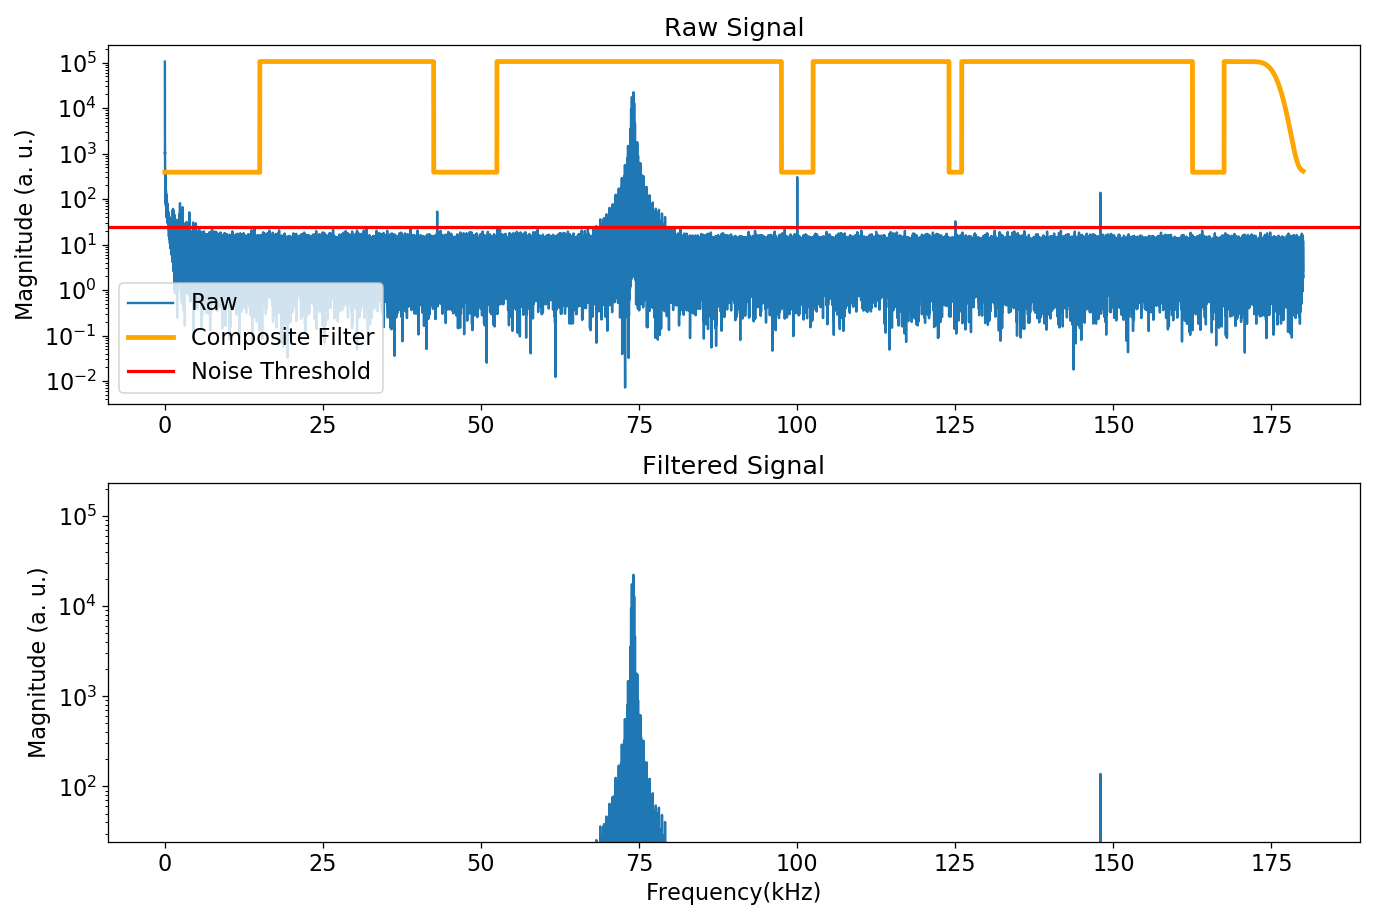

In [14]:
# Test filter on a single line:
row_ind = 7
    
if Filter_data:
    # Set Filter parameters here:
    num_spectral_pts = h5_main.shape[1]
    
    ##############################################################################################################################
    #### Here you can play with Low Pass Filter
    ################################################################################################################
    lpf = px.processing.fft.LowPassFilter(num_pts, samp_rate, 180E+3) # low pass filter
    
     ##############################################################################################################################
    #### Here you can play with Noise band filter
    ################################################################################################################
    nbf = px.processing.fft.NoiseBandFilter(num_pts, samp_rate, [125E+3,45E+3, 50E+3, 5E+3, 100E+3, 165E+3], [2E+3,5E+3, 5E+3, 20E+3, 5E+3, 5E+3 ])
    
    ################################################################################################################################
    #### Here you can play with Noise Noise tolerance
    ################################################################################################################
     
    noise_tolerance = 0.0000001
    
    freq_filts = [lpf, nbf]
   
   
  
    excit_wfm = h5_spec_vals[-1]

    filt_line, fig_filt, axes_filt = px.processing.gmode_utils.test_filter(h5_main[row_ind], 
                                                                           frequency_filters=freq_filts, 
                                                                           noise_threshold=noise_tolerance, 
                                                                           show_plots=True)
    plt.tight_layout(pad=1.0, w_pad=1.0, h_pad=1.0)



#### Here you can take a look at your filtered data in the time domain at some random pixels

<IPython.core.display.Javascript object>


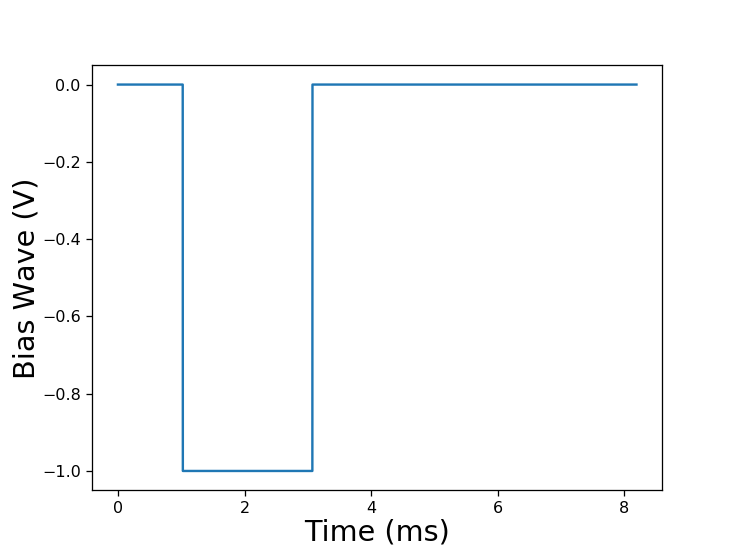

<IPython.core.display.Javascript object>


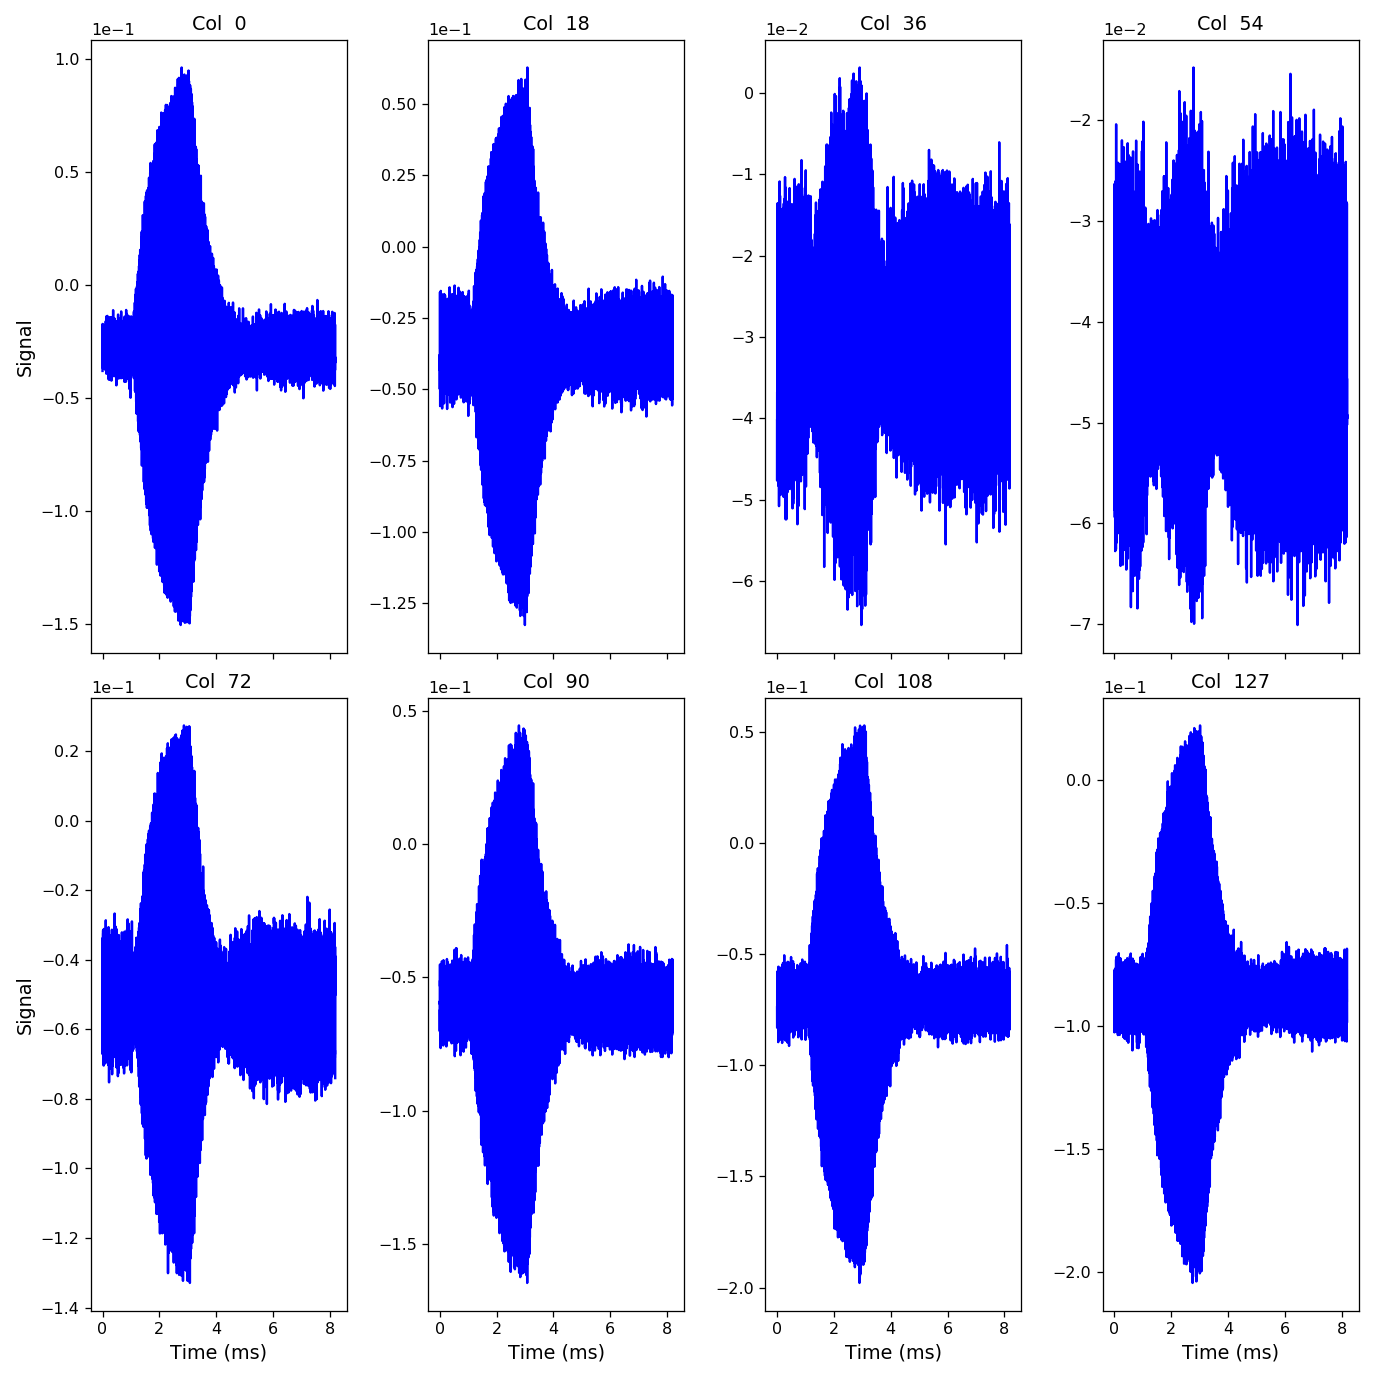

<IPython.core.display.Javascript object>


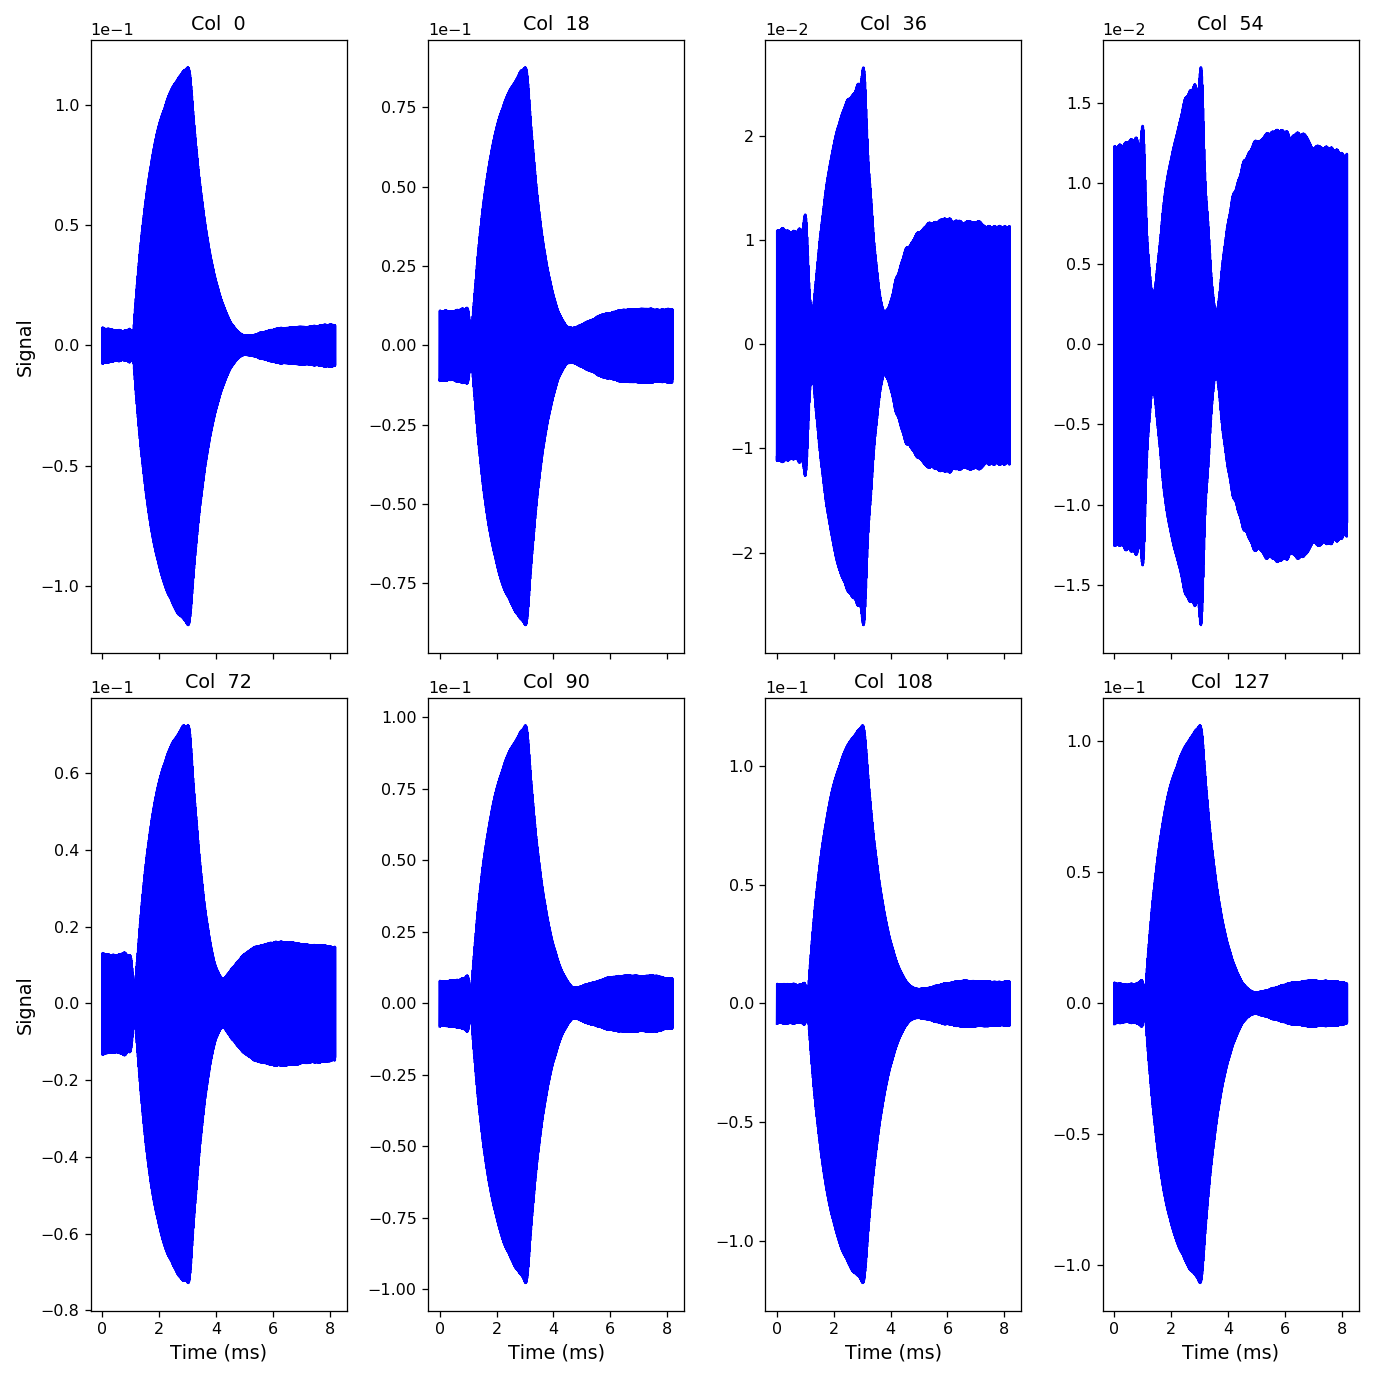

In [15]:
if Filter_data:
    # Test filter on a single line:
    plt.figure()
    plt.plot(t_vec_pix,pulse_wave)
    plt.xlabel('Time (ms)', fontsize=18, labelpad=1)
    plt.ylabel('Bias Wave (V)', fontsize=18, labelpad=1)

      
    raw_pix=np.reshape(h5_main[row_ind],[num_cols,-1])
    filt2_pix=np.reshape(filt_line,[num_cols,-1])
    
  
    fig_loops, axes_loops = usid.plot_utils.plot_curves(t_vec_pix,raw_pix, line_colors=['b'], x_label='Time (ms)',
                                                        y_label='Signal', subtitle_prefix='Col ', num_plots=8,
                                                        title='RAW RESPONSE',use_rainbow_plots=False)
    
    fig_loops, axes_loops = usid.plot_utils.plot_curves(t_vec_pix,filt2_pix, line_colors=['r'], x_label='Time (ms)',
                                                    y_label='Signal', subtitle_prefix='Col ', num_plots=8,
                                                    title='FILTERED RESPONSE',use_rainbow_plots=False)

  

## Now we can Fourier filter the entire data set


In [16]:
   
if Filter_data:
    parm_dict = dict()
    for filter in freq_filts:
        parm_dict.update(filter.get_parms())
    parm_dict['noise_threshold'] = noise_tolerance
    parm_dict['num_pix'] = h5_main.shape[0]
    h5_filt_grp = usid.hdf_utils.check_for_old(h5_main, 'FFT_Filtering', new_parms=parm_dict)
   
    
    if len(h5_filt_grp) > 0:
        print('Taking previously filtered results')
        h5_filt_grp = h5_filt_grp[-1]
    else:
        print('FFT filtering not performed on this dataset. Filtering now:')


    sig_filt = px.processing.SignalFilter(h5_main, frequency_filters=freq_filts, noise_threshold=noise_tolerance,
                                              write_filtered=True, write_condensed=False, num_pix=1, verbose=True)

    h5_filt_grp = sig_filt.compute()

    h5_filt = h5_filt_grp['Filtered_Data']
   
    
    
elif not Filter_data:
    
    
    h5_filt = px.hdf_utils.find_dataset(hdf, 'Filtered_Data')[-1]
    
    

FFT filtering not performed on this dataset. Filtering now:
Allowed to read 97 pixels per chunk
Allowed to use up to 10 cores and 4096 MB of memory
Consider calling test() to check results before calling compute() which computes on the entire dataset and writes back to the HDF5 file
Allowed to read 32 pixels per chunk
Checking for duplicates:
Creating datagroup and datasets
h5 group and file OK
quantity, units, main_data_name all OK
Selected empty dataset creation. OK so far
Provided h5 position indices and values OK
Passed all pre-tests for creating spectroscopic datasets
Indices:
[[0]]
Values:
[[1.]]
Starting to write Region References to Dataset /Measurement_000/Channel_000/Raw_Data-FFT_Filtering_001/Noise_Spec_Indices of shape: (1, 1)
About to write region reference: arb : (slice(0, 1, None), slice(None, None, None))
Comparing (slice(0, 1, None), slice(None, None, None)) with h5 dataset maxshape of (1, 1)
Region reference tuple now: [slice(0, 1, None), slice(None, None, None)]
Wrot

In [17]:
usid.hdf_utils.print_tree(hdf)

/
├ Measurement_000
  ---------------
  ├ CPD_000
    -------
    ├ CPD
    ├ CPD-Cluster_000
      ---------------
      ├ Cluster_Indices
      ├ Cluster_Values
      ├ Labels
      ├ Mean_Resp_Pos_Indices
      ├ Mean_Resp_Pos_Values
      ├ Mean_Response
    ├ CPD-Cluster_001
      ---------------
      ├ Cluster_Indices
      ├ Cluster_Values
      ├ Labels
      ├ Mean_Resp_Pos_Indices
      ├ Mean_Resp_Pos_Values
      ├ Mean_Response
    ├ CPD-SVD_000
      -----------
      ├ Position_Indices
      ├ Position_Values
      ├ S
      ├ Spectroscopic_Indices
      ├ Spectroscopic_Values
      ├ U
      ├ V
    ├ CPDExpFitting_000
      -----------------
      ├ Position_Indices
      ├ Position_Values
      ├ Spectroscopic_Indices
      ├ Spectroscopic_Values
      ├ fit_param
    ├ CPDExpFitting_001
      -----------------
      ├ Position_Indices
      ├ Position_Values
      ├ Spectroscopic_Indices
      ├ Spectroscopic_Values
      ├ fit_param
    ├ CPDExpFitting_on_000
     

## Next we can perform Spectral Unmixing

Here we use SVD eigenvector decomposition 

Note this method produces non-physical eigenvectors. Caution should be taken when attempting to interpret  eigenvectors and abundance maps from SVD decomposition.

Nonetheless, for KPFM, and non-contact SPM in general, the data can usually be well described (>90% information retention)by the first few components.

I find its a good method for quickly visualizing the major trends in the dataset, and for isolating components which are related purely to instrument/measurement noise. Sometimes, it is useful to use SVD for data cleaning through the reconstruction of the dataset using only the first N (most significant) components.

**Data needs to be reshapes into a 2D array (rows*cols,points per location)**<br>
**SVD results in three matrices:**

    V - Eigenvectors sorted by variance in descending order
    U - corresponding abundance maps
    S - Variance or importance of each of these components


In [18]:
################################################################################################################
##### This reshapes the data into (rows*cols, N_points)                                                    #####
################################################################################################################

h5_resh = px.processing.gmode_utils.reshape_from_lines_to_pixels(h5_filt, pixel_ex_wfm.size, img_length / num_cols)
h5_resh_grp = h5_resh.parent

print(h5_resh)

Starting to reshape G-mode line data. Please be patient
Finished reshaping G-mode line data to rows and columns
<HDF5 dataset "Reshaped_Data": shape (8192, 16384), type "<f2">
located at: 
	/Measurement_000/Channel_000/Raw_Data-FFT_Filtering_001/Filtered_Data-Reshape_000/Reshaped_Data 
Data contains: 
	D (V) 
Data dimensions and original shape: 
Position Dimensions: 
	X - size: 128 
	Y - size: 64 
Spectroscopic Dimensions: 
	Excitation - size: 16384
Data Type:
	float16


Consider calling test() to check results before calling compute() which computes on the entire dataset and writes back to the HDF5 file
Took 21.04 sec to compute randomized SVD


<IPython.core.display.Javascript object>


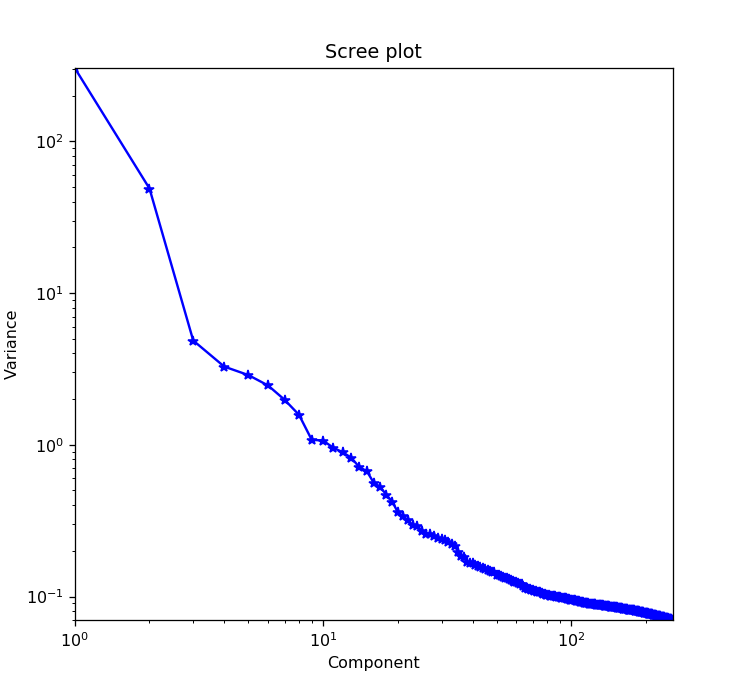

<IPython.core.display.Javascript object>


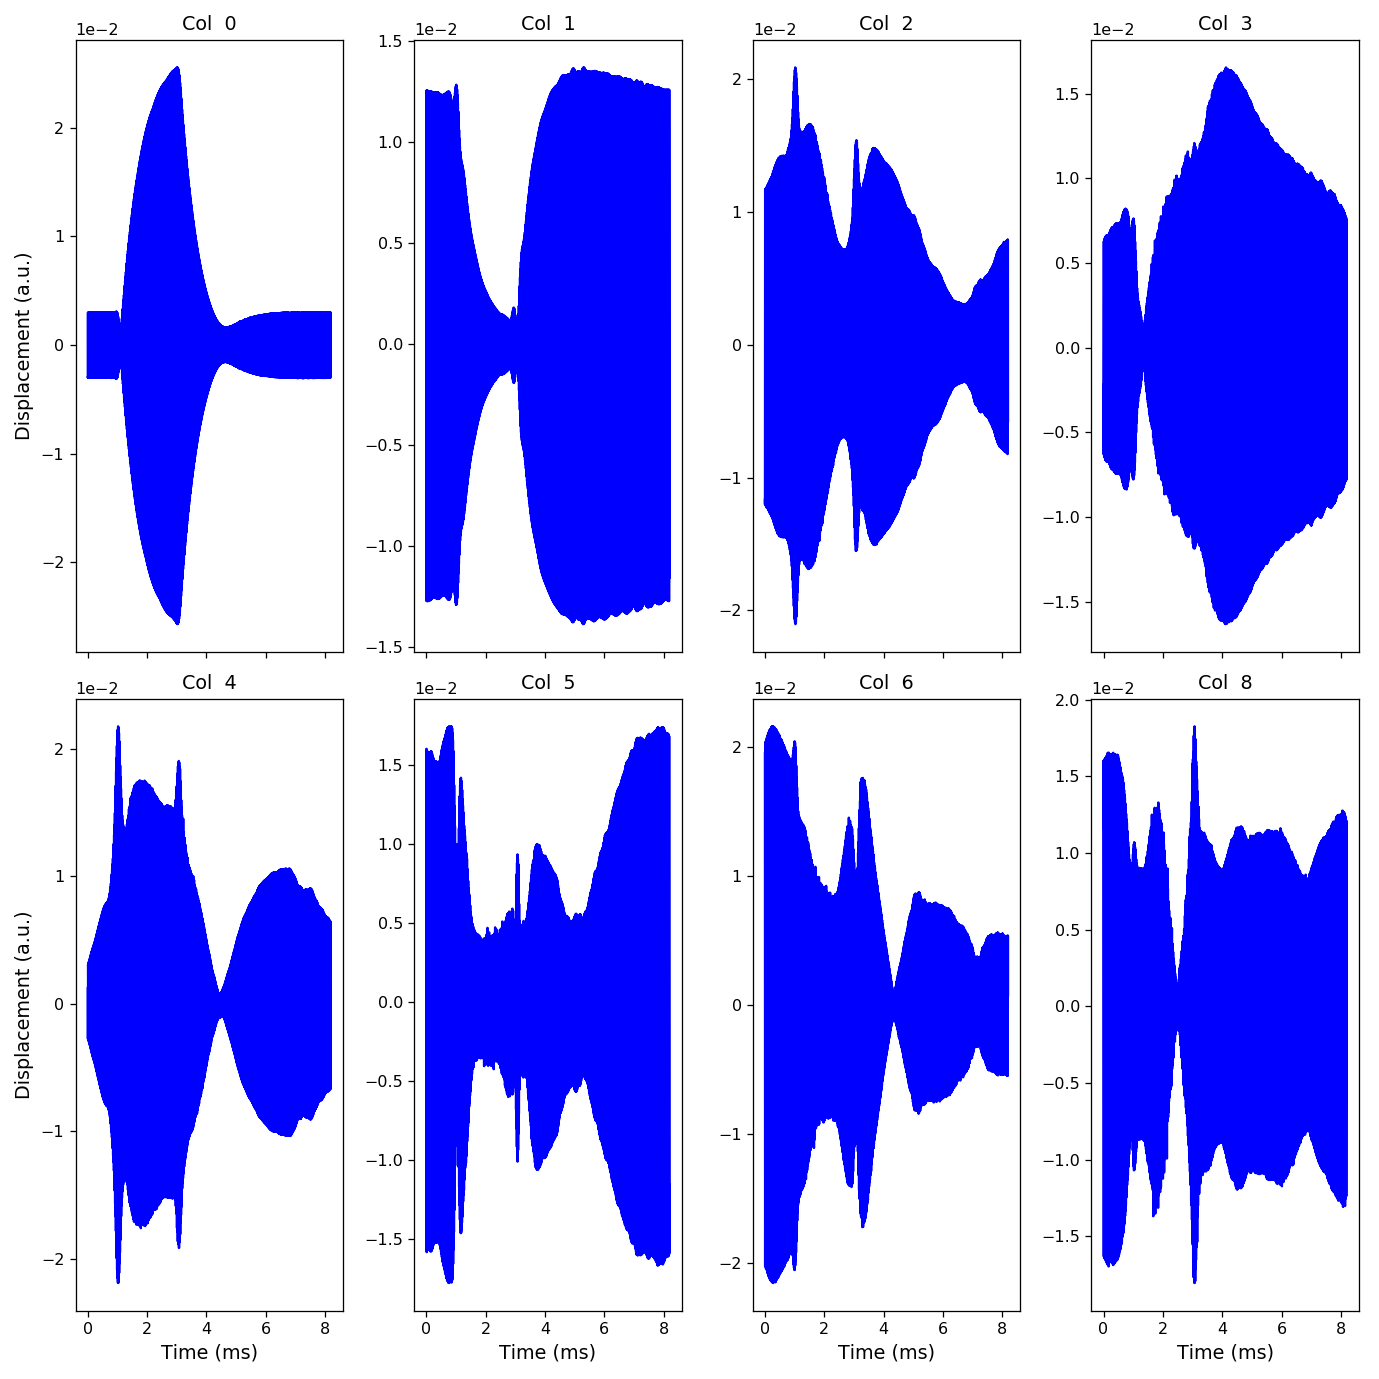

<IPython.core.display.Javascript object>


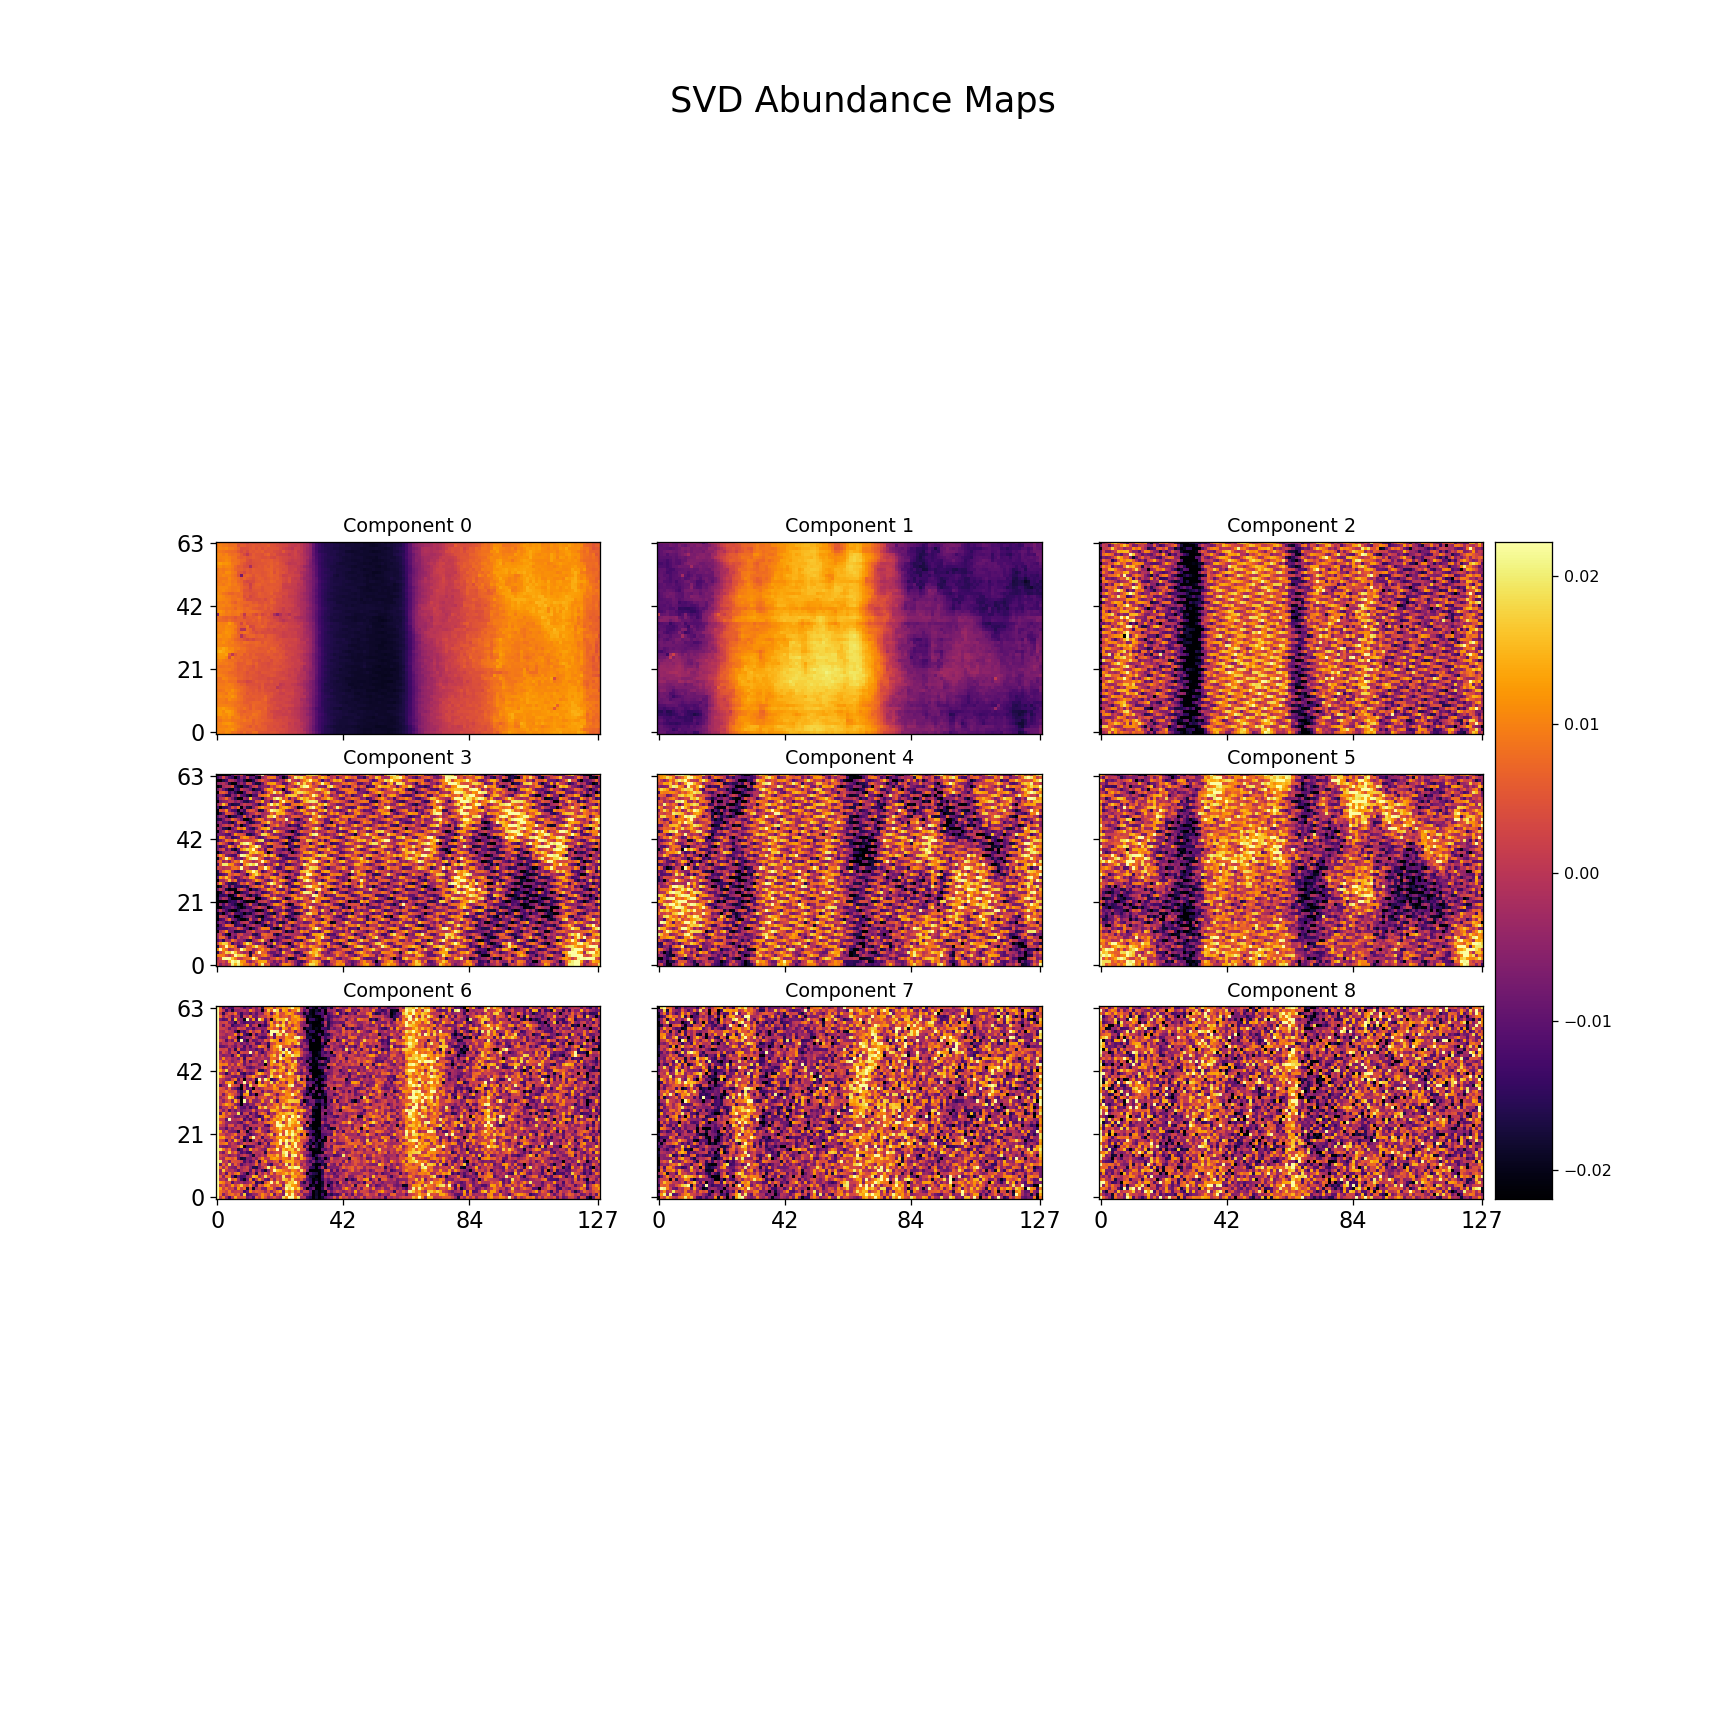

In [19]:

if do_SVD_denoise:

    do_svd = px.processing.svd_utils.SVD(h5_resh, num_components=256)
    h5_svd_group = do_svd.compute()

    h5_u = h5_svd_group['U']
    h5_v = h5_svd_group['V']
    h5_s = h5_svd_group['S']

    # Since the two spatial dimensions (x, y) have been collapsed to one, we need to reshape the abundance maps:
    abun_maps = np.reshape(h5_u[:,:25], (num_rows, num_cols,-1))

    # Visualize the variance / statistical importance of each component:
    usid.plot_utils.plot_scree(h5_s, title='Scree plot')

    if save_figure == True:
        plt.savefig(output_filepath+'\PCARaw_Scree_2.tif', format='tiff')


    # Visualize the eigenvectors:
    first_evecs = h5_v[:9, :]
    fig, axes = usid.plot_utils.plot_curves(t_vec_pix, first_evecs, line_colors=['r'], x_label='Time (ms)',
                                                    y_label='Displacement (a.u.)', subtitle_prefix='Col ', num_plots=8,
                                                    title='SVD Eigenvectors (F$^{3}$R)',use_rainbow_plots=False)


    if save_figure == True:
        plt.savefig(output_filepath+'\PCARaw_Eig_2.tif', format='tiff')


    # Visualize the abundance maps:
    usid.plot_utils.plot_map_stack(abun_maps, num_comps=9, title='SVD Abundance Maps', reverse_dims=True,
                                 color_bar_mode='single', cmap='inferno', title_yoffset=0.95)
 

    if save_figure == True:
        plt.savefig(output_filepath+'\PCARaw_Loading_2.tif', format='tiff')


  
    

Above you see the Skree plot, as well as the first 9 Eigenvectors and abundance maps for the Fourier filtered PD response.

The eigenvectors are representatitive of tip displacement vs time per pixel. The cantilever response to the pulse wave (plotted earlier) is complex, a mixture of inherent cantilever dynamics and true electrostatic interactions.

The abundance maps can clearly discern locations in the sample corresponding the source and drain electrode under the sample. Interestingly, the second and higher components indicate spatial variability in the region between electrodes which can be indicitive of space charge region dynamics at the interfaces

<IPython.core.display.Javascript object>


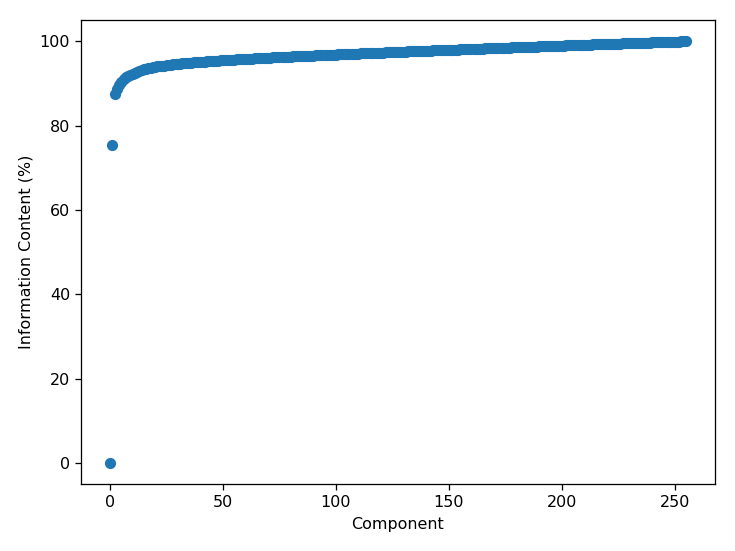

Need to include 2 components for 80% information retention
Need to include 5 components for 90% information retention
Need to include 38 components for 95% information retention


In [20]:
if do_SVD_denoise:
    skree_sum = np.zeros(h5_s.shape)

    for i in range(h5_s.shape[0]):
        skree_sum[i] = np.sum(h5_s[:i])/np.sum(h5_s)

    plt.figure()
    plt.plot(skree_sum*100, 'o')
    plt.xlabel("Component")
    plt.ylabel("Information Content (%)")
    plt.tight_layout()
    print('Need to include', skree_sum[skree_sum<0.8].shape[0],'components for 80% information retention')
    print('Need to include', skree_sum[skree_sum<0.9].shape[0],'components for 90% information retention')
    print('Need to include', skree_sum[skree_sum<0.95].shape[0],'components for 95% information retention')
    if save_figure == True:
      plt.savefig(output_filepath+'\Skree%.tif', format='tiff')

      

In this case I do not want to SVD denoise my data. The information is spread across a large range of eigenvectors. I find for clean G-KPFM datasets the first 9 components can usually describe 95-98% of the information content. This can change considerable if there are corrupted data points in your dataset. 

If I wanted to SVD clean my data I could run:

    svd_utils.rebuild_svd(h5_main, components=clean_components)

Where clean_components is a 1d array of components to be included in the rebuild
    
    

## Step 3. Fast Free Force Reconstruction 

Below we perform fast free recovery of the electrostatic force by dividing the filtered response by the effective transfer function. We futher set a noise treshold, above which is included in the iFFT transform into the time domain

       
#### (3) Fast Free Force Reconstruction   
**(3a)** Divides filtered displacement Y(w) by the effective transfer function (H(w)). <br>
**(3b)** iFFT the response above a user defined noise floor to recovery Force in time domain.<br>



<IPython.core.display.Javascript object>


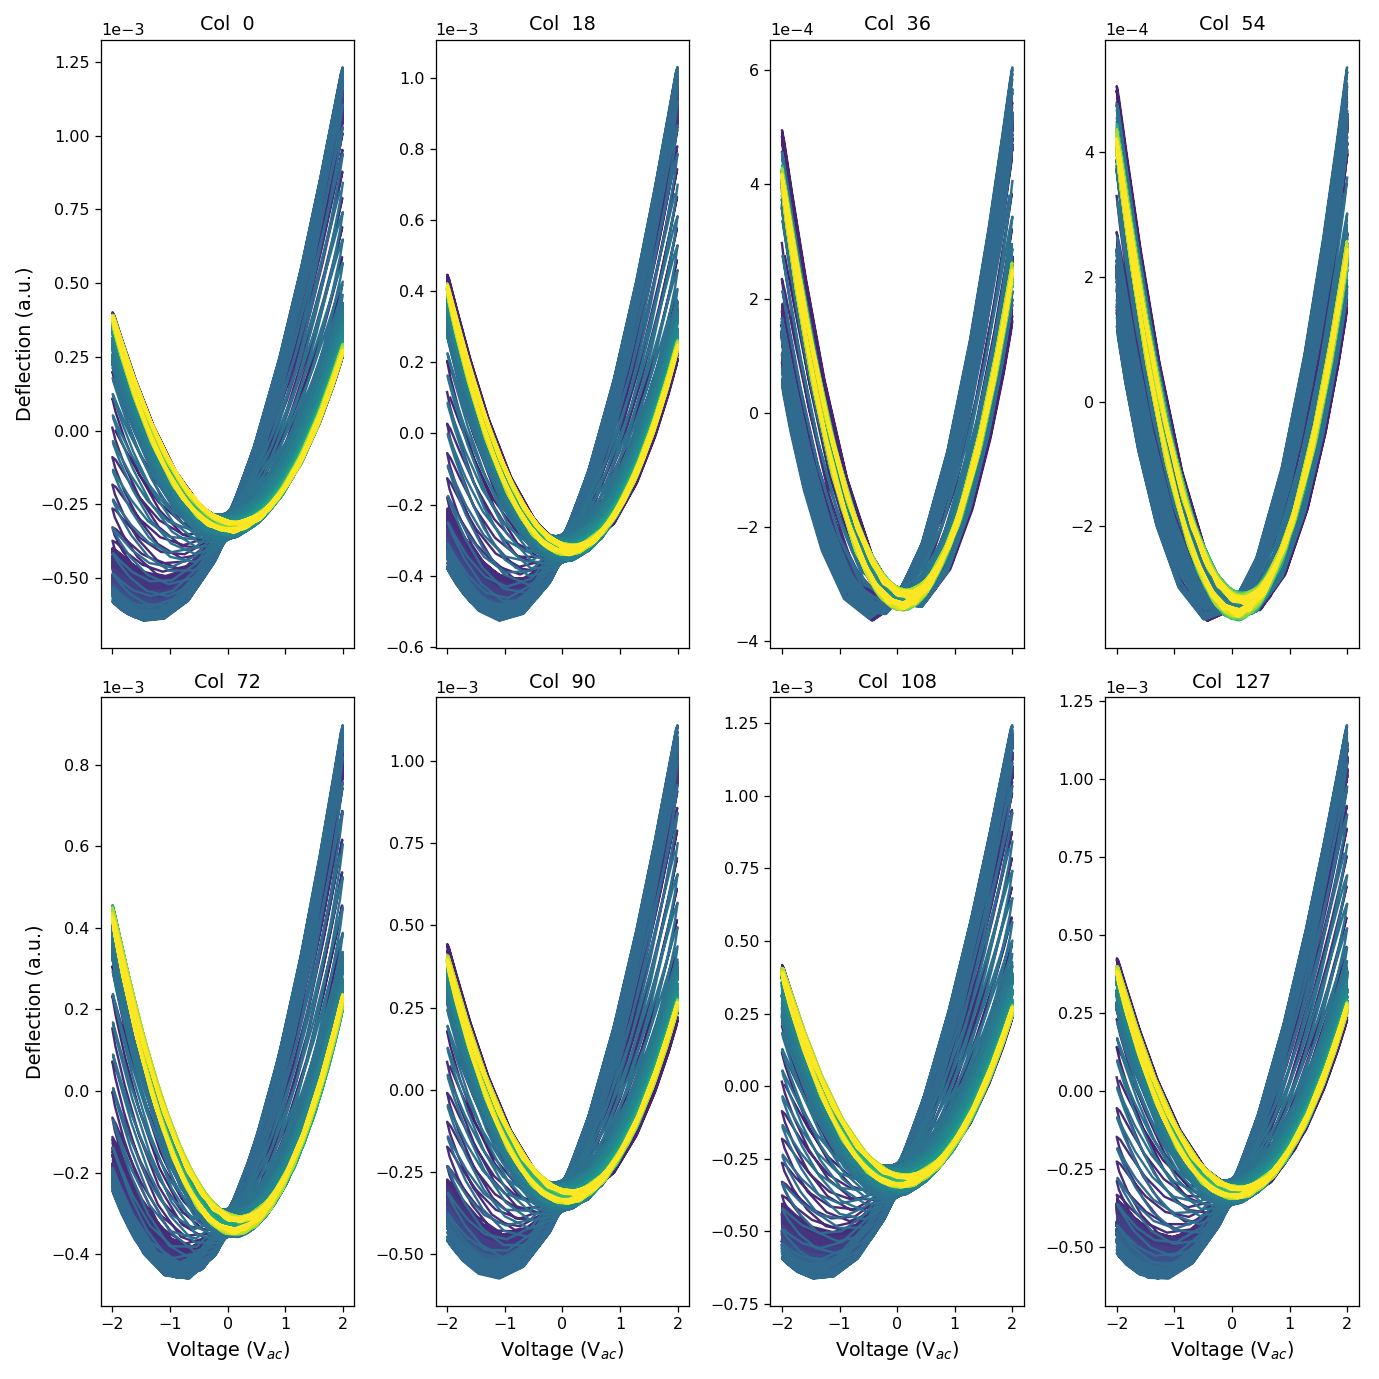

In [21]:
ph=-0.52 #Phase offset
Noiselimit = 5; #Phase offset

signal_ind_vec=np.arange(w_vec.size)
ind_drive = (np.abs(w_vec*1e3-ex_freq)).argmin()

if DO_F3R:
    
    #########################################################################################################
    ### Function
    #########################################################################################################
    def scale_by_tune(filt_vec, w_vec, ph, ind_drive, TF_norm):
        G=np.zeros(w_vec.size,dtype=complex)
        signal_keep=[]
            
        tmp_time=filt_vec-np.mean(filt_vec)
        tmp=np.fft.fftshift(np.fft.fft(tmp_time))
        signal_keep = np.argwhere(np.abs(tmp)>=Noiselimit).squeeze()
        tmp *= np.exp(-1j*w_vec*1E3/(w_vec[ind_drive]*1E3)*ph)
        G[signal_keep]=tmp[signal_keep]
        G_time=np.real(np.fft.ifft(np.fft.ifftshift(G/TF_norm)))
        
        return G_time
    

    
    #########################################################################################################
    ### Perform F3R in parallel -- You should change n_jobs to match #cores you want to use 
    #########################################################################################################
    
    num_cores=4
    raw_data = h5_filt[()]
    
    scaling_kwargs = {'w_vec': w_vec2,
                     'ph': ph,
                     'ind_drive': ind_drive,
                     'TF_norm': TF_norm}
    
    results = usid.processing.parallel_compute(raw_data, scale_by_tune, 
                                               cores=num_cores, 
                                               func_kwargs=scaling_kwargs)
    
    G_time = np.array(results)

    del results
    
    #########################################################################################################
    ### Storing and Reshaping
    #########################################################################################################
    
    F3R_pos_vals=np.squeeze(h5_main.h5_pos_vals.value)
    F3R_pos_inds=h5_main.h5_pos_inds
    F3R_spec_vals = np.squeeze(h5_main.h5_spec_vals.value)
    F3R_spec_inds = h5_main.h5_spec_inds 

    F3R_pos_dim = px.hdf_utils.Dimension('Rows', 'um', F3R_pos_vals)
    F3R_spec_dim = px.hdf_utils.Dimension('Bias', 'V', F3R_spec_vals)

    F3R_grp = px.hdf_utils.create_indexed_group(h5_main.parent, 'F3R_Results')
    
    px.hdf_utils.write_simple_attrs(F3R_grp, {'Noise Level': Noiselimit,
                                                'Phase': ph})
    
    h5_F3R = px.hdf_utils.write_main_dataset(F3R_grp, G_time, 'F3R_data', 
                                           'Response', 'a.u.',
                                          F3R_pos_dim, F3R_spec_dim)
    hdf.file.flush()
    
elif not DO_F3R:   
    G_time = px.hdf_utils.find_dataset(hdf, 'F3R_data')[-1]

###################################
### Check a single row
###################################

raw=G_time[row_ind].reshape(-1,pixel_ex_wfm.size)



fig, axes = usid.plot_utils.plot_curves(pixel_ex_wfm, raw, line_colors=['r'], x_label='Voltage (V$_{ac}$)',
                                                y_label='Deflection (a.u.)', subtitle_prefix='Col ', num_plots=8,
                                                title='F3R results',use_rainbow_plots=True)

In [22]:
###################################
### Reshape Data
###################################

G_time = px.hdf_utils.find_dataset(hdf, 'F3R_data')[-1]
h5_resh_grp = px.core.hdf_utils.find_results_groups(G_time,'F3R_data')

if len(h5_resh_grp) > 0:
    print('Taking previously reshaped results')
    h5_resh_grp = h5_resh_grp[-1]
    h5_resh = px.hdf_utils.find_dataset(hdf,'Reshaped_Data')[0]
    
else:
    print('Reshape not performed on this dataset. Reshaping now:')
    scan_width = 1
    h5_resh = px.processing.gmode_utils.reshape_from_lines_to_pixels(h5_F3R, pixel_ex_wfm.size, scan_width / num_cols)
    h5_resh_grp = h5_resh.parent



px.hdf_utils.print_tree(hdf)
print(h5_resh)

Taking previously reshaped results
/
├ Measurement_000
  ---------------
  ├ CPD_000
    -------
    ├ CPD
    ├ CPD-Cluster_000
      ---------------
      ├ Cluster_Indices
      ├ Cluster_Values
      ├ Labels
      ├ Mean_Resp_Pos_Indices
      ├ Mean_Resp_Pos_Values
      ├ Mean_Response
    ├ CPD-Cluster_001
      ---------------
      ├ Cluster_Indices
      ├ Cluster_Values
      ├ Labels
      ├ Mean_Resp_Pos_Indices
      ├ Mean_Resp_Pos_Values
      ├ Mean_Response
    ├ CPD-SVD_000
      -----------
      ├ Position_Indices
      ├ Position_Values
      ├ S
      ├ Spectroscopic_Indices
      ├ Spectroscopic_Values
      ├ U
      ├ V
    ├ CPDExpFitting_000
      -----------------
      ├ Position_Indices
      ├ Position_Values
      ├ Spectroscopic_Indices
      ├ Spectroscopic_Values
      ├ fit_param
    ├ CPDExpFitting_001
      -----------------
      ├ Position_Indices
      ├ Position_Values
      ├ Spectroscopic_Indices
      ├ Spectroscopic_Values
      ├ fit_par

In [23]:
usid.hdf_utils.get_attributes(h5_resh_grp)

{'machine_id': 'pc95969.ornl.gov',
 'timestamp': '2018_07_23-16_30_19',
 'pycroscopy_version': '0.60.1',
 'platform': 'Windows-7-6.1.7601-SP1',
 'tool': 'Reshape',
 'num_source_dsets': 1,
 'source_000': <HDF5 object reference>}


### Parabolic Fitting of Cleaned Data




<IPython.core.display.Javascript object>


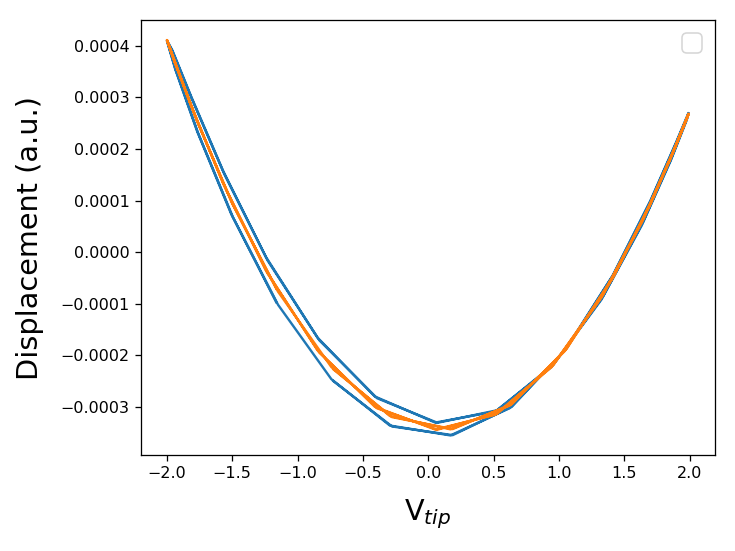

No handles with labels found to put in legend.


In [24]:
##########################################
### DO parabolic fitting of single point
##########################################

time_per_osc = 1/parms_dict['BE_center_frequency_[Hz]']
IO_rate = parms_dict['IO_rate_[Hz]']

N_points_per_pixel = parms_dict['num_bins']
pxl_time = N_points_per_pixel/IO_rate
num_periods = int(pxl_time // (time_per_osc*2))
pnts_per_per = int(N_points_per_pixel // num_periods)

time = np.linspace(0,pxl_time,num_periods)

deg = 2

n = 2
m = 2
k4 = 22

resp = h5_resh[m, pnts_per_per*k4:pnts_per_per*(k4+1)]

resp = resp-np.mean(resp)

V_per_osc = pixel_ex_wfm[pnts_per_per*k4:pnts_per_per*(k4+1)]
p1,s = npPoly.polyfit(V_per_osc,resp,deg,full=True)
y1 = npPoly.polyval(V_per_osc,p1)

plt.figure()
plt.plot(V_per_osc, resp)
plt.plot(V_per_osc, y1)
plt.legend(fontsize=16)
plt.xlabel('V$_{tip}$', fontsize=18, labelpad=10)
plt.ylabel('Displacement (a.u.)', fontsize=18, labelpad=10)
plt.tight_layout()

if save_figure == True:
    plt.savefig(output_filepath+'\Fitting.tif', format='tiff')

     

## Repeat on the full dataset

In [25]:
if do_para_fit:

    def fit_cleaned(data_vec, pixel_ex_wfm, pnts_per_per, num_periods, deg):
        fit = np.zeros([num_periods, deg+1])
        for k4 in range(num_periods):#osc_period
            resp=data_vec[pnts_per_per*k4:pnts_per_per*(k4+1)]
            resp=resp-np.mean(resp)
            V_per_osc=pixel_ex_wfm[pnts_per_per*k4:pnts_per_per*(k4+1)]
            p1,s=npPoly.polyfit(V_per_osc,resp,deg,full=True)
            y1=npPoly.polyval(V_per_osc,p1)           

            fit[k4,:]=p1
        return fit
    
    fit_cleaned_dict = {'pixel_ex_wfm': pixel_ex_wfm,
                        'pnts_per_per': pnts_per_per,
                        'num_periods': num_periods,
                        'deg': deg}
    
    results = usid.processing.parallel_compute(h5_resh[()], fit_cleaned, 
                                               cores=num_cores,
                                               func_kwargs=fit_cleaned_dict)
    
    #change n_jobs below as approraite to the number of cores you want to use
    wHfit3 = np.array(results)

    CPD=0.5*np.divide(wHfit3[:,:,1],wHfit3[:,:,0]) 

    del results
    
    ##########################################
    ### Save CPD to HD5 (need to change to save all fit)
    ##########################################
    
        
    CPD_pos_vals=np.arange(0,num_rows*num_cols)
    CPD_spec_vals = time 

    CPD_pos_dim = px.hdf_utils.Dimension('Rows', 'um', CPD_pos_vals)
    CPD_spec_dim = px.hdf_utils.Dimension('Time', 'S', CPD_spec_vals)

    CPD_grp = px.hdf_utils.create_indexed_group(h5_main.parent.parent, 'CPD')
    
    h5_CPD = px.hdf_utils.write_main_dataset(CPD_grp, CPD, 'CPD', 
                                             'CPD', 'V',
                                             pos_dims, CPD_spec_dim)
    
    hdf.file.flush()
    
elif not do_para_fit:
    px.hdf_utils.print_tree(hdf)
    h5_CPD = px.hdf_utils.find_dataset(hdf,'CPD')[-1]
    CPD=h5_CPD

/
├ Measurement_000
  ---------------
  ├ CPD_000
    -------
    ├ CPD
    ├ CPD-Cluster_000
      ---------------
      ├ Cluster_Indices
      ├ Cluster_Values
      ├ Labels
      ├ Mean_Resp_Pos_Indices
      ├ Mean_Resp_Pos_Values
      ├ Mean_Response
    ├ CPD-Cluster_001
      ---------------
      ├ Cluster_Indices
      ├ Cluster_Values
      ├ Labels
      ├ Mean_Resp_Pos_Indices
      ├ Mean_Resp_Pos_Values
      ├ Mean_Response
    ├ CPD-SVD_000
      -----------
      ├ Position_Indices
      ├ Position_Values
      ├ S
      ├ Spectroscopic_Indices
      ├ Spectroscopic_Values
      ├ U
      ├ V
    ├ CPDExpFitting_000
      -----------------
      ├ Position_Indices
      ├ Position_Values
      ├ Spectroscopic_Indices
      ├ Spectroscopic_Values
      ├ fit_param
    ├ CPDExpFitting_001
      -----------------
      ├ Position_Indices
      ├ Position_Values
      ├ Spectroscopic_Indices
      ├ Spectroscopic_Values
      ├ fit_param
    ├ CPDExpFitting_on_000
     

In [26]:
CPD.shape

(8192, 302)

## Data Visualization 
#### Plot single point

<IPython.core.display.Javascript object>


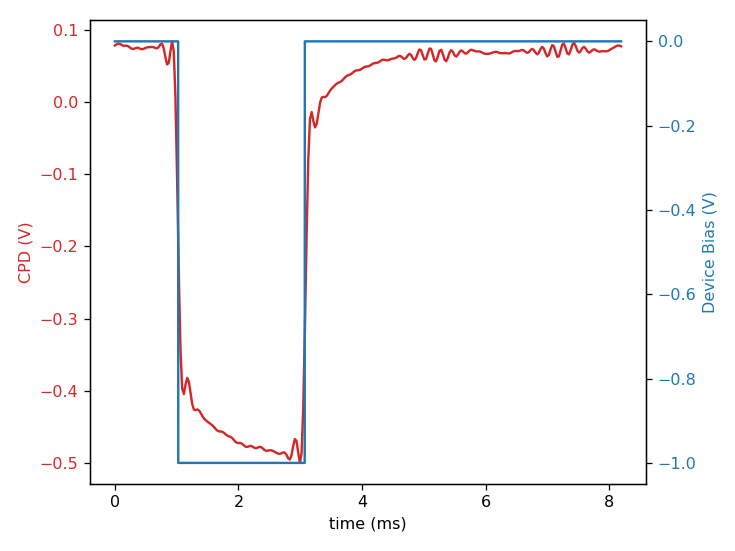

In [27]:
time = np.linspace(0,pxl_time,num_periods)

##########################################
### Plot Single Point
##########################################

test=CPD[150,:]
time=np.linspace(0.0,pxl_time,num_periods)

fig, ax1 = plt.subplots()
color = 'tab:red'
ax1.set_xlabel('time (ms)')
ax1.set_ylabel('CPD (V)', color=color)
ax1.plot(time*1000, test, color=color)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis


color = 'tab:blue'
ax2.set_ylabel('Device Bias (V)', color=color)  # we already handled the x-label with ax1
ax2.plot(t_vec_pix,pulse_wave, color=color)
ax2.tick_params(axis='y', labelcolor=color)

fig.tight_layout()  # otherwise the right y-label is slightly clipped
#plt.show()


if save_figure == True:
  plt.savefig(output_filepath+'\CPD_vs_time.tif', format='tiff')

      


## Do SVD Spectral Unmixing on the 3D CPD(x,y,time) dataset

Consider calling test() to check results before calling compute() which computes on the entire dataset and writes back to the HDF5 file
Note: SVD has already been performed PARTIALLY with the same parameters. compute() will resuming computation in the last group below. To choose a different group call use_patial_computation()Set override to True to force fresh computation or resume from a data group besides the last in the list.
[<HDF5 group "/Measurement_000/CPD_000/CPD-SVD_000" (7 members)>]
Took 507.51 msec to compute randomized SVD


<IPython.core.display.Javascript object>


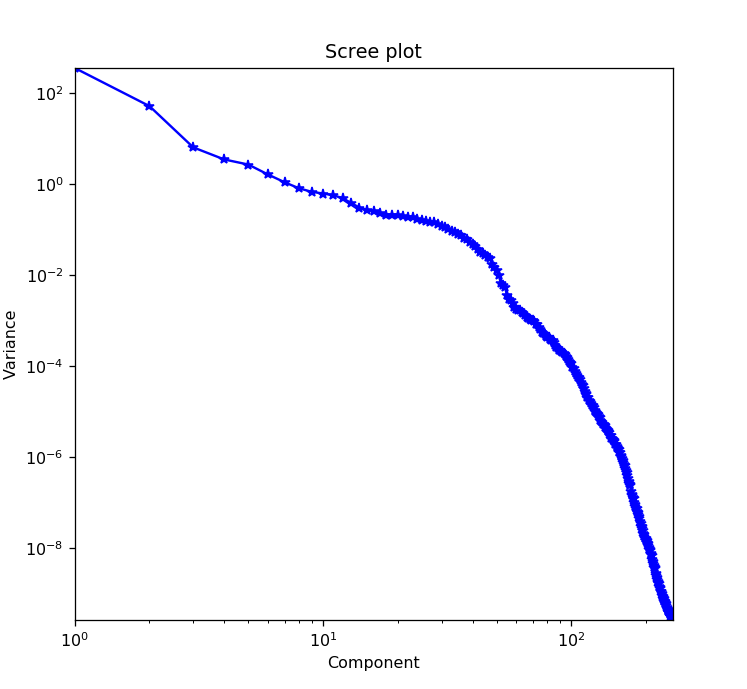

<IPython.core.display.Javascript object>


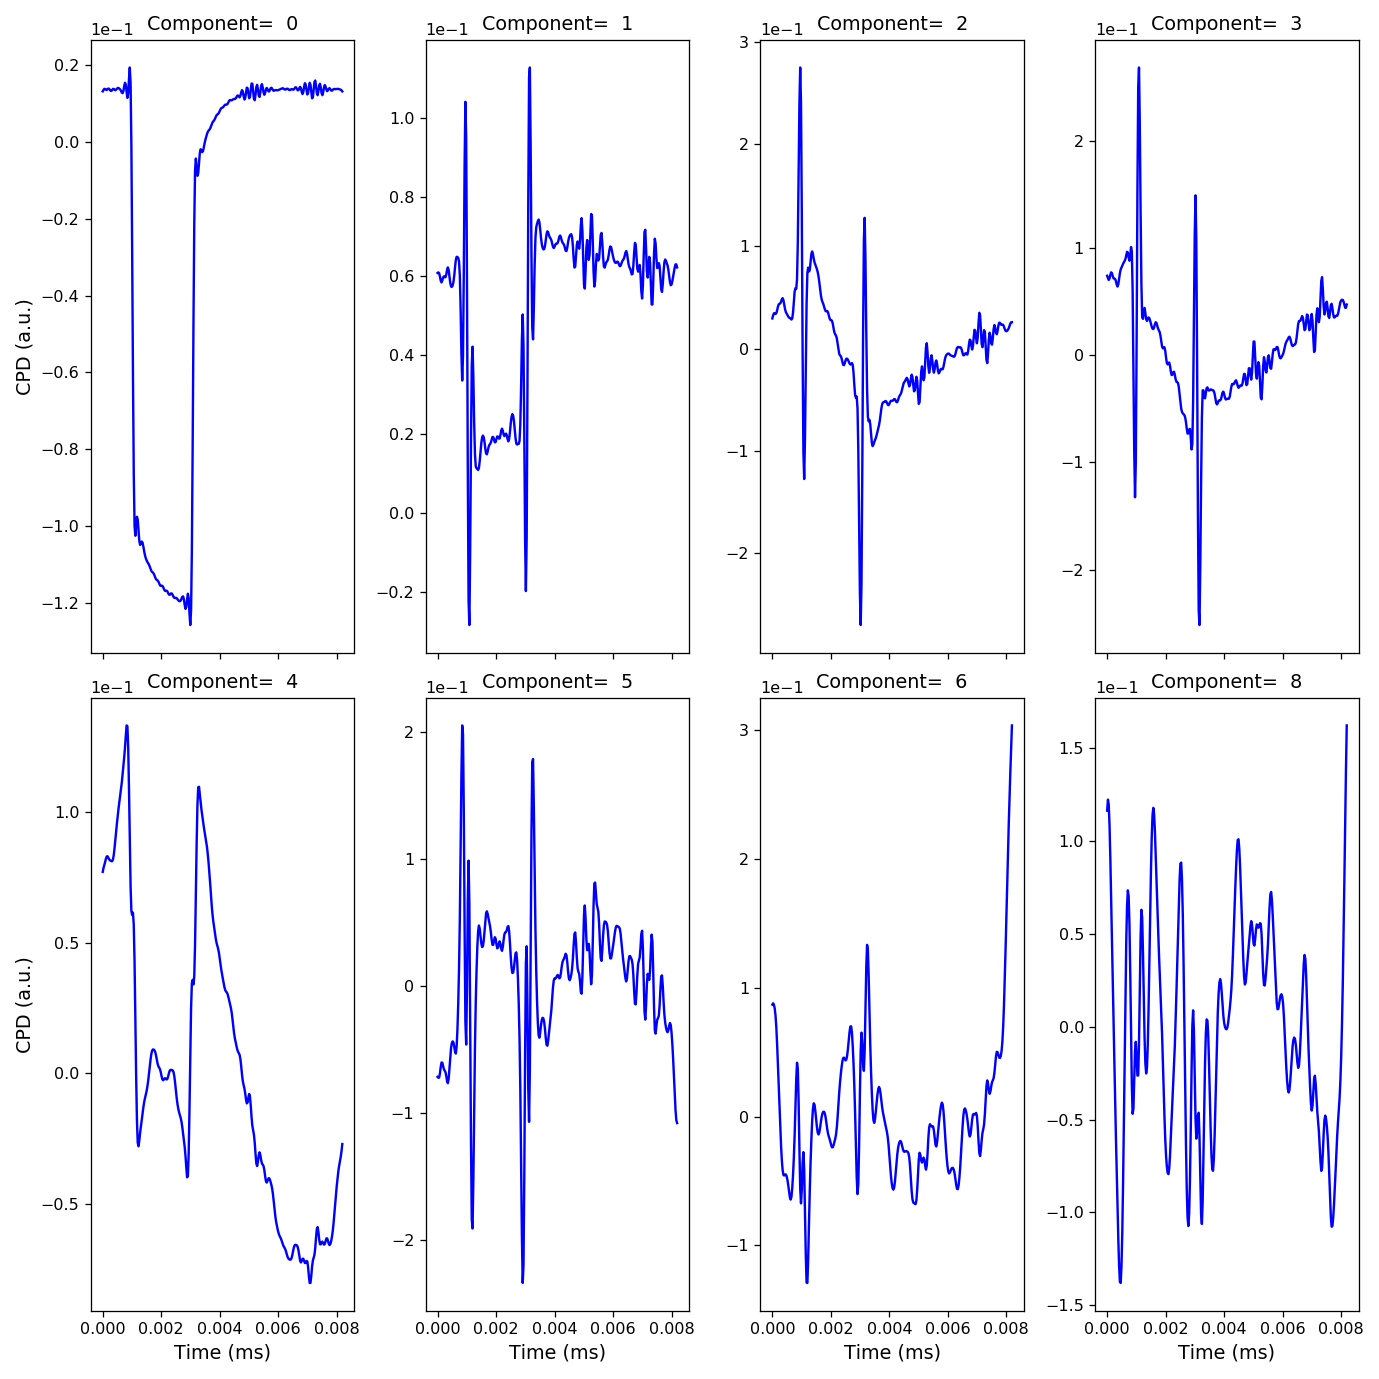

<IPython.core.display.Javascript object>


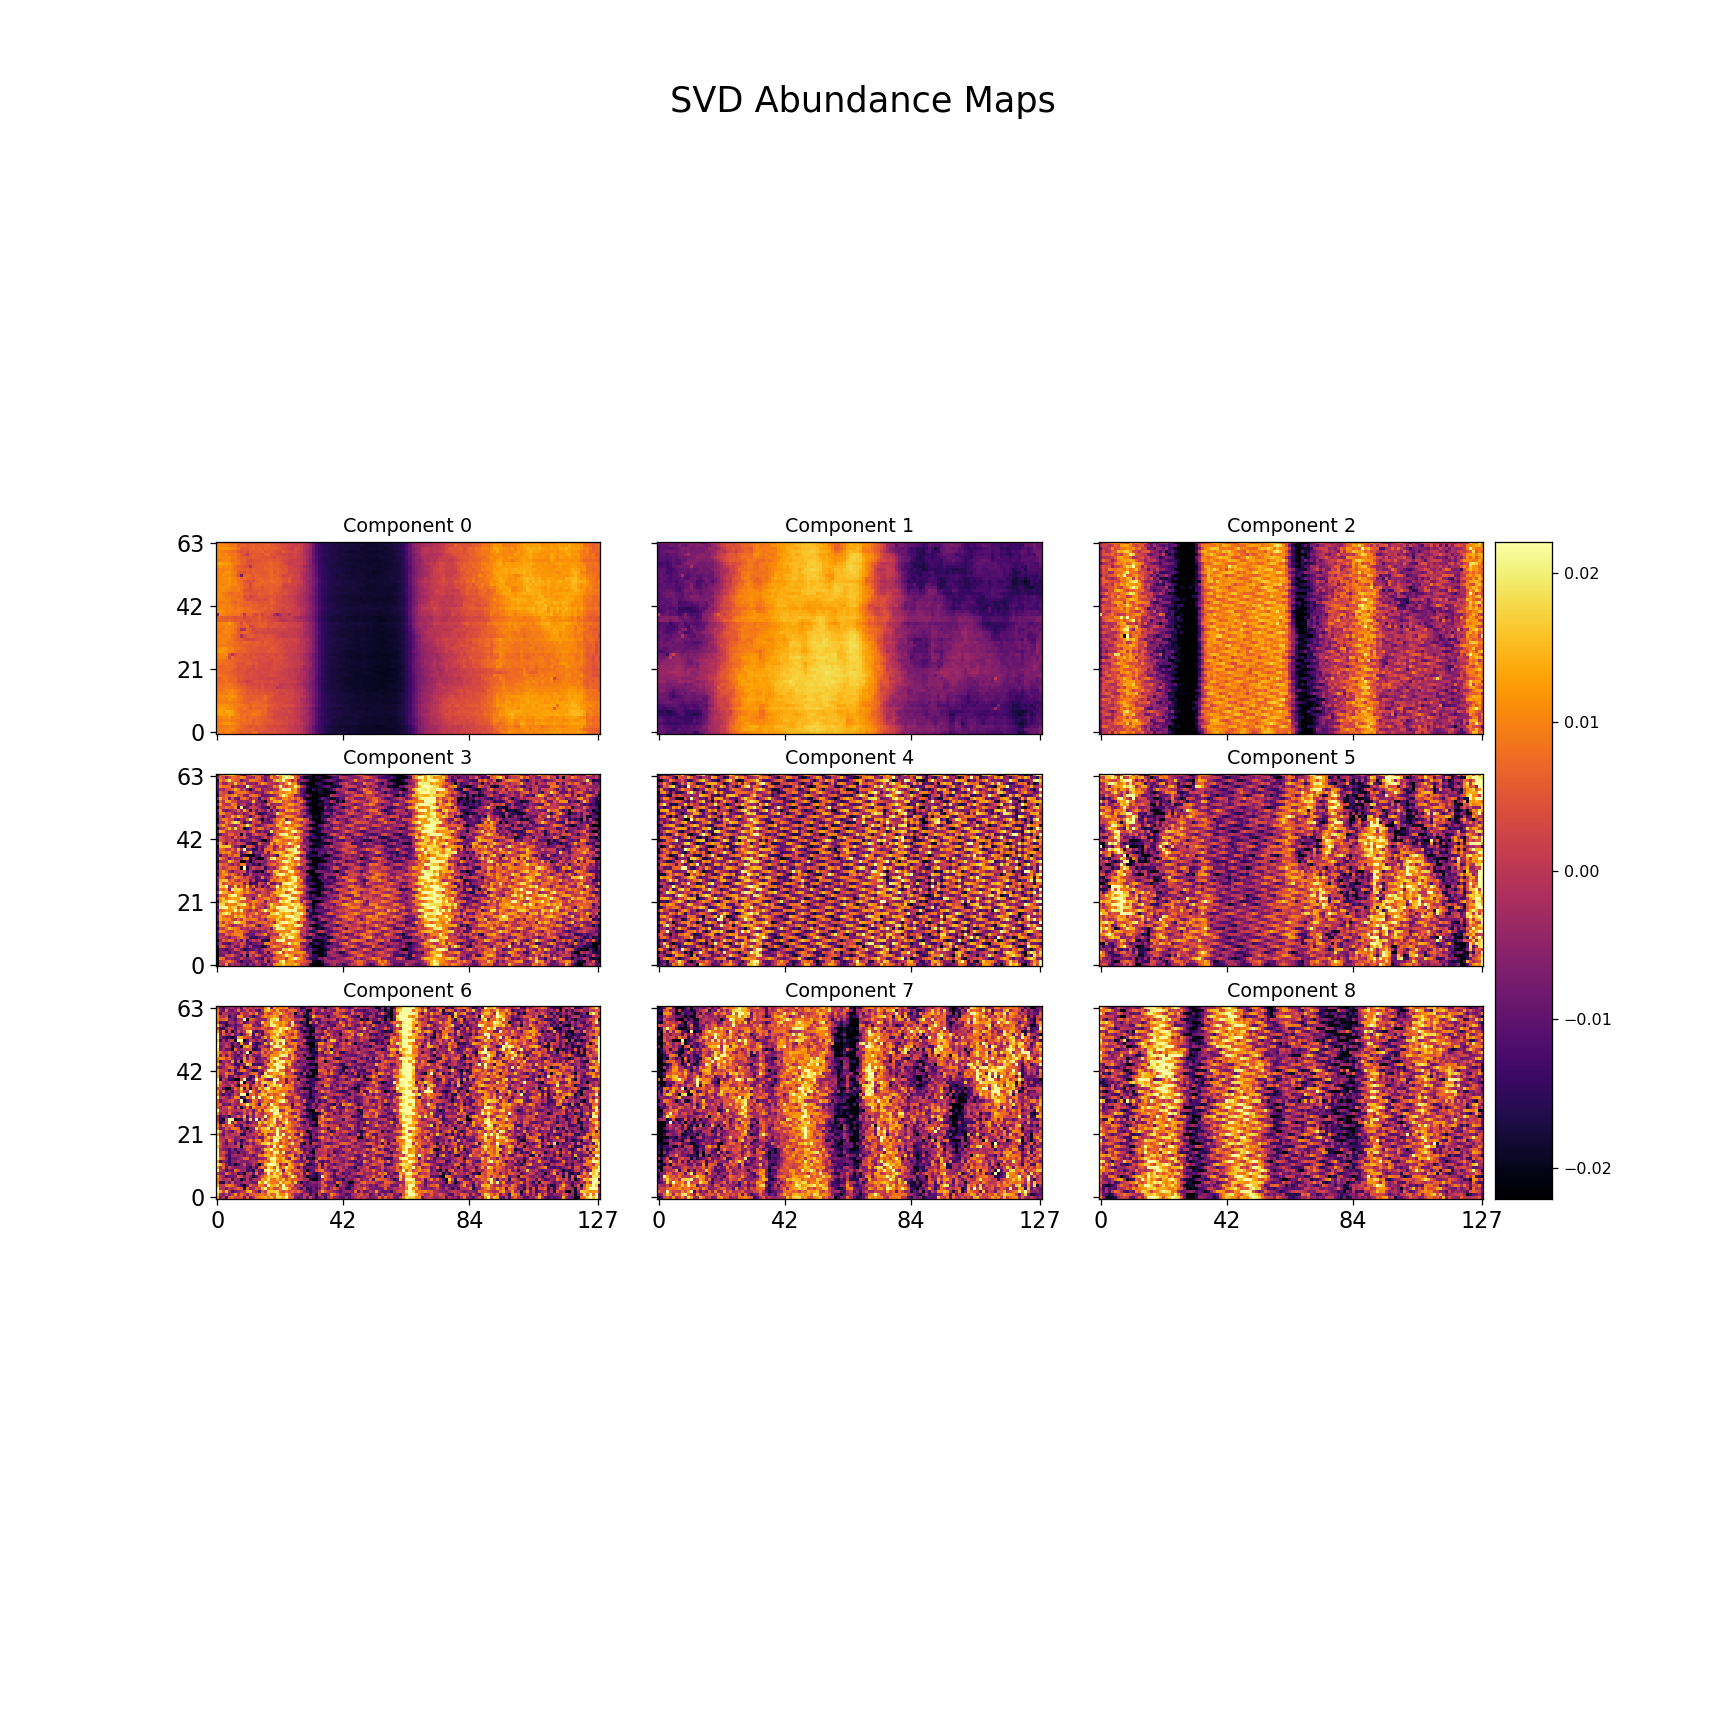

In [28]:

if do_SVD_CPD: #
    ##########################################
    ### DO PCA of CPD results
    ##########################################

    do_svd = px.processing.svd_utils.SVD(h5_CPD, num_components=256)
    h5_svd_group = do_svd.compute(override=True)

    h5_u = h5_svd_group['U']
    h5_v = h5_svd_group['V']
    h5_s = h5_svd_group['S']

    # Since the two spatial dimensions (x, y) have been collapsed to one, we need to reshape the abundance maps:
    abun_maps = np.reshape(h5_u[:,:25], (num_rows, num_cols,-1))

    # Visualize the variance / statistical importance of each component:
    usid.plot_utils.plot_scree(h5_s, title='Scree plot')

    if save_figure == True:
        plt.savefig(output_filepath+'\PCARaw_Scree_CPD.tif', format='tiff')


    # Visualize the eigenvectors:
    first_evecs = h5_v[:9, :]

    fig, axes = usid.plot_utils.plot_curves(time, first_evecs, line_colors=['r'], x_label='Time (ms)',
                                                    y_label='CPD (a.u.)', subtitle_prefix='Component= ', num_plots=8,
                                                    title='SVD Eigenvectors (CPD data)',use_rainbow_plots=False)


    if save_figure == True:
        plt.savefig(output_filepath+'\PCARaw_Eig_CPD.tif', format='tiff')


    # Visualize the abundance maps:
    usid.plot_utils.plot_map_stack(abun_maps, num_comps=9, title='SVD Abundance Maps', reverse_dims=True,
                                 color_bar_mode='single', cmap='inferno', title_yoffset=0.95)


    if save_figure == True:
    #     fig.savefig(output_filepath+'\PCARaw_Loading.eps', format='eps')
    #     fig.savefig(output_filepath+'\PCARaw_Loading.tif', format='tiff')
        plt.savefig(output_filepath+'\PCARaw_Loading_CPD.tif', format='tiff')
        #save_figure = False;


## Do kMeans Clustering

KMeans clustering is a quick method to determine the types of spectral responses present in the data. It is not a decomposition method, but a basic clustering method. The user inputs the number of clusters (sets) to partition the data into. 

Performing K-means now
Consider calling test() to check results before calling compute() which computes on the entire dataset and writes back to the HDF5 file
Performing clustering on /Measurement_000/CPD_000/CPD.
Took 5.11 sec to compute KMeans
Calculated the Mean Response of each cluster.
Starting computing on 1 cores (requested 1 cores)
Computing serially ...
Took 110.0 msec to calculate mean response per cluster
Writing clustering results to file.


<IPython.core.display.Javascript object>


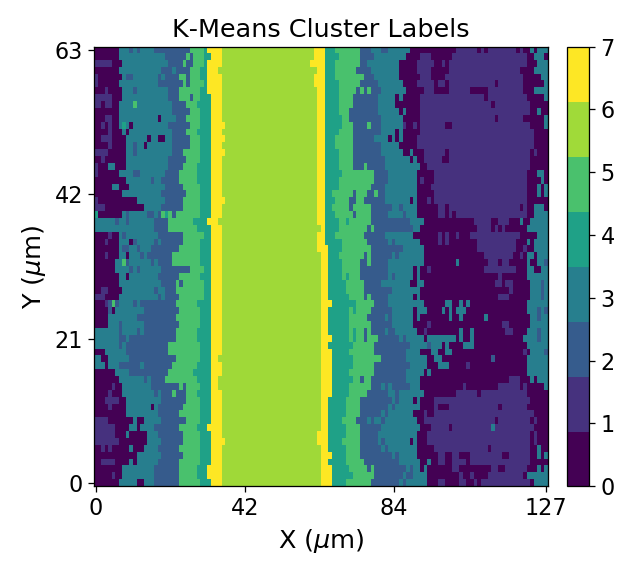

<IPython.core.display.Javascript object>


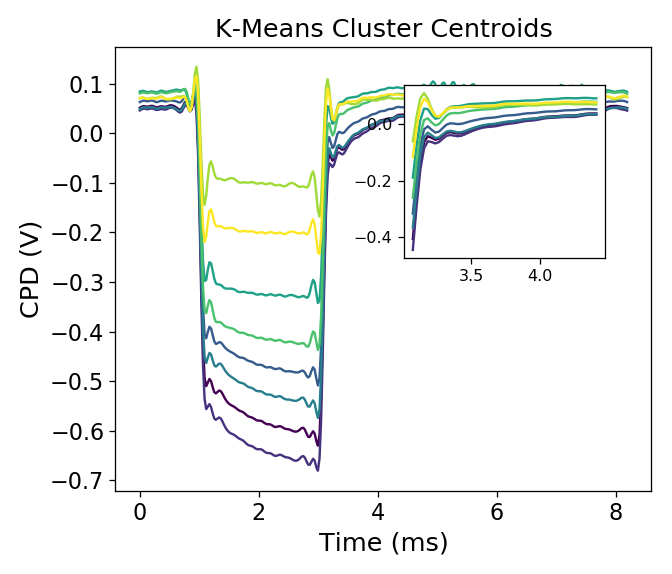

C:\Users\lz1\AppData\Local\Continuum\anaconda3\lib\site-packages\matplotlib\figure.py:2267: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


In [29]:

if do_Kmeans: #
    ##########################################
    ### DO Kmeans clustering
    ##########################################
    time = np.linspace(0.0, pxl_time, CPD.shape[1])

    ##########################################
    ### Pick aproriate times here for fitting
    ##########################################
    d1=np.where(np.abs(pulse_wave)>0) 
    dtCPD = pxl_time/(CPD.shape[1]-1) #dt for the CPD since not same length as raw data
    t_on =t_vec_pix[d1[0][0]]
    t_off =t_vec_pix[d1[0][-1]]
    p_off = int(t_off*1e-3 / dtCPD)+1    
        

    time_off = time[p_off:(p_off+10)]   # last point is sometimes NaN for some reason  

    def plot_cluster_results_separately(labels_mat, cluster_centroids, bias_vec, legend_mode=1, **kwargs):
        num_clusters = cluster_centroids.shape[0]
        fig_lab, axis_lab = plt.subplots(figsize=(5.5,5))
        _, _ = px.plot_utils.plot_map(axis_lab, labels_mat, 
                                                  clim=[0, num_clusters-1], 
                                                  cmap=plt.get_cmap('viridis', num_clusters), 
                                                  aspect='auto', show_xy_ticks=True, **kwargs)
        axis_lab.set_xlabel('X ($\mu$m)', fontsize=16)
        axis_lab.set_ylabel('Y ($\mu$m)', fontsize=16)
        axis_lab.set_title('K-Means Cluster Labels', fontsize=16)
        fig_lab.tight_layout()



        # Plot centroids
        fig_width = 5.0
        if legend_mode not in [0, 1]:
            fig_width = 5.85
        fig_centroids, axis_centroids = plt.subplots(figsize=(fig_width, 5))
        colors = [ plt.cm.viridis(x) for x in np.linspace(0, 1, cluster_centroids.shape[0]) ]

        left, bottom, width, height = [0.60, 0.55, 0.3, 0.3]
        #left, bottom, width, height = [0.60, 0.15, 0.3, 0.3]
        ax2 = fig_centroids.add_axes([left, bottom, width, height])

        # print('Number of pixels in each cluster:')
        for line_ind in range(cluster_centroids.shape[0]):
            cmap=plt.cm.jet
            line_color=colors[line_ind]
            line_label = 'Cluster ' + str(line_ind)
           # num_of_cluster_members = len(np.where(labels==line_ind)[0])
            # print ("Cluster " + str(line_ind) + ': ' + str(num_of_cluster_members))
            #if num_of_cluster_members > 10:
            ax2.plot(bias_vec[p_off:(p_off+50)], cluster_centroids[line_ind,p_off:(p_off+50)],
                                label=line_label, color=line_color) # marker='o', 

            axis_centroids.plot(bias_vec, cluster_centroids[line_ind,:],
                                label=line_label, color=line_color) # marker='o', 
        axis_centroids.set_xlabel('Time (ms)', fontsize=16)
        axis_centroids.set_ylabel('CPD (V)', fontsize=16)
        axis_centroids.set_title('K-Means Cluster Centroids', fontsize=16)
        if legend_mode==0:
            axis_centroids.legend(loc='lower right', fontsize=14)
        elif legend_mode==1:
            axis_centroids.legend(loc='upper left', bbox_to_anchor=(1, 1), fontsize=14)
        else:
            sm = px.plot_utils.make_scalar_mappable(0, num_clusters-1, 
                                                   cmap=px.plot_utils.discrete_cmap(num_clusters))
           # plt.colorbar(sm)
        px.plot_utils.set_tick_font_size(axis_centroids, 14)
        fig_centroids.tight_layout()

        return fig_lab, fig_centroids

  

    h5_CPD = px.hdf_utils.find_dataset(hdf,'CPD')[-1]


    num_clusters = 8


    print('Performing K-means now')
    estimator = px.processing.Cluster(h5_CPD, KMeans(n_clusters=num_clusters))
    h5_kmeans_grp = estimator.compute(h5_CPD,override=True)


    h5_kmeans_labels = h5_kmeans_grp['Labels']
    h5_kmeans_centroids = h5_kmeans_grp['Mean_Response']
    fig_lab, fig_centroids = plot_cluster_results_separately(h5_kmeans_labels[:,:].reshape(num_rows, num_cols), 
                                                            h5_kmeans_centroids[:,:], time*1000, legend_mode=2)
    
    if save_figure == True:
    #     fig.savefig(output_filepath+'\PCARaw_Loading.eps', format='eps')
    #     fig.savefig(output_filepath+'\PCARaw_Loading.tif', format='tiff')
        fig_lab.savefig(output_filepath+'\KmeansLabels.tif', format='tiff')
        fig_centroids.savefig(output_filepath+'\KmeansCentroids.tif', format='tiff')
        #save_figure = False;

In [30]:
h5_CPD.shape

(8192, 302)

# NMF

Consider calling test() to check results before calling compute() which computes on the entire dataset and writes back to the HDF5 file
Note: Decomposition has already been performed with the same parameters before. These results will be returned by compute() by default. Set override to True to force fresh computation
[<HDF5 group "/Measurement_000/CPD_000/CPD-Decomposition_000" (6 members)>]
Returning previously computed results from: /Measurement_000/CPD_000/CPD-Decomposition_000
set the "override" flag to True to recompute results


<IPython.core.display.Javascript object>


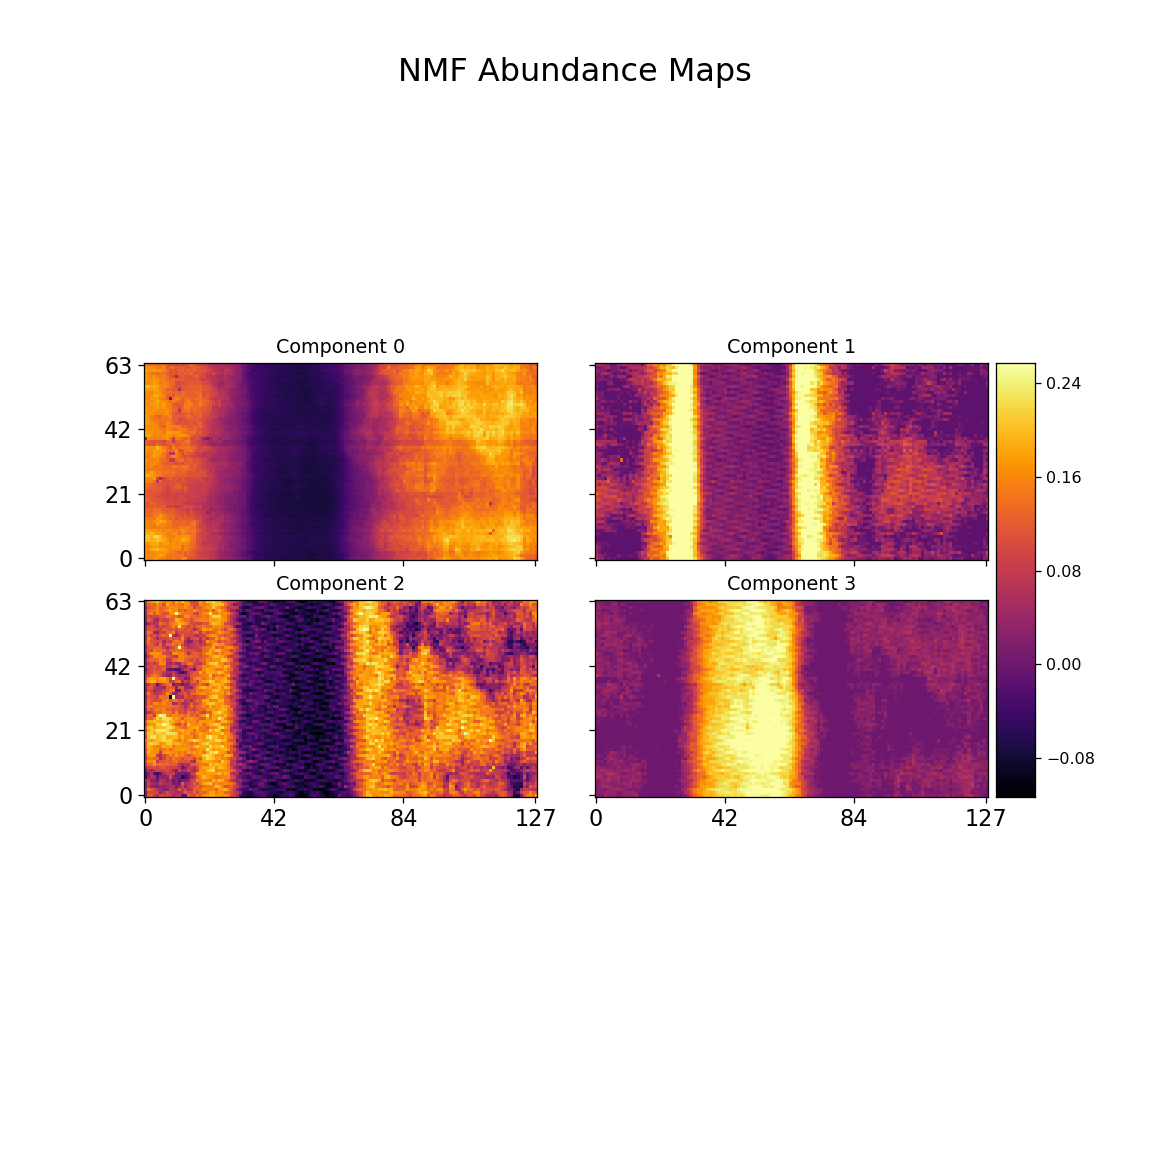

<IPython.core.display.Javascript object>


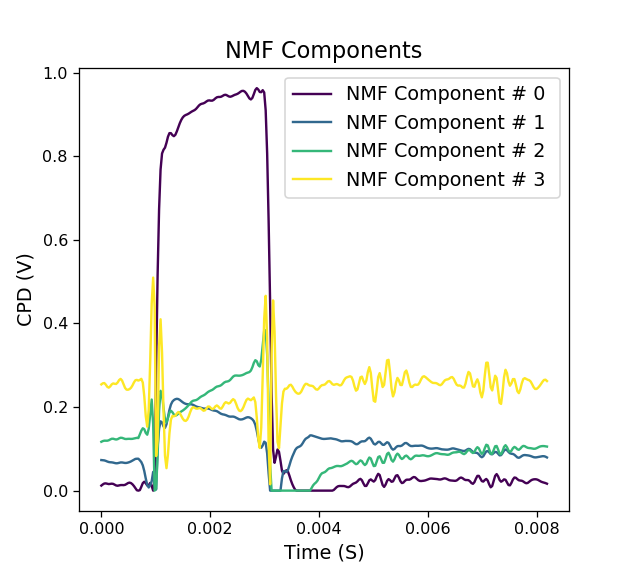

In [42]:

# Extracting the X axis - vector of frequencies
h5_spec_vals = usid.hdf_utils.get_auxiliary_datasets(h5_CPD, 'Spectroscopic_Values')[-1]
#Get X,Y labels

x_label = h5_CPD.spec_dim_descriptors[0]
y_label = h5_CPD.data_descriptor

num_comps = 4

#Choose the NMFmodel from sklearn
nmf_model = NMF(n_components=num_comps, init='random', random_state=0)

#data_mat = np.abs(h5_CPD[:]) #get the data, ensuring it is positive only.

#pycroscopy can handle this decomposition given an sklearn estimator object
decomposer = px.processing.decomposition.Decomposition( h5_CPD, estimator =nmf_model)
h5_nmf_group = decomposer.compute() #compute it. Saves results into the file and returns reference to it.

components1 = h5_nmf_group['Components'] #Components 
projection  = h5_nmf_group['Projection'] #Coefficients/scores
components  =components1[:]

nmf_coeffs_fig = usid.plot_utils.plot_map_stack(projection[:].reshape(num_rows,num_cols,-1), num_comps=9, title='NMF Abundance Maps', reverse_dims=True,
                             color_bar_mode='single', cmap='inferno', title_yoffset=0.95)

# Visualize the components:
nmf_comp_fig, axis = plt.subplots(figsize=(5.5, 5))
usid.plot_utils.plot_line_family(axis, h5_spec_vals[:].ravel(), components, label_prefix='NMF Component #')
axis.set_xlabel(x_label, fontsize=12)
axis.set_ylabel(y_label, fontsize=12)
axis.set_title('NMF Components', fontsize=14)
axis.legend(bbox_to_anchor=[1.0, 1.0], fontsize=12)


In [103]:
my_data = h5_CPD[:].reshape(num_rows*num_cols,-1)

from sklearn.decomposition import NMF

C:\Users\lz1\AppData\Local\Continuum\anaconda3\lib\site-packages\matplotlib\pyplot.py:537: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


<IPython.core.display.Javascript object>


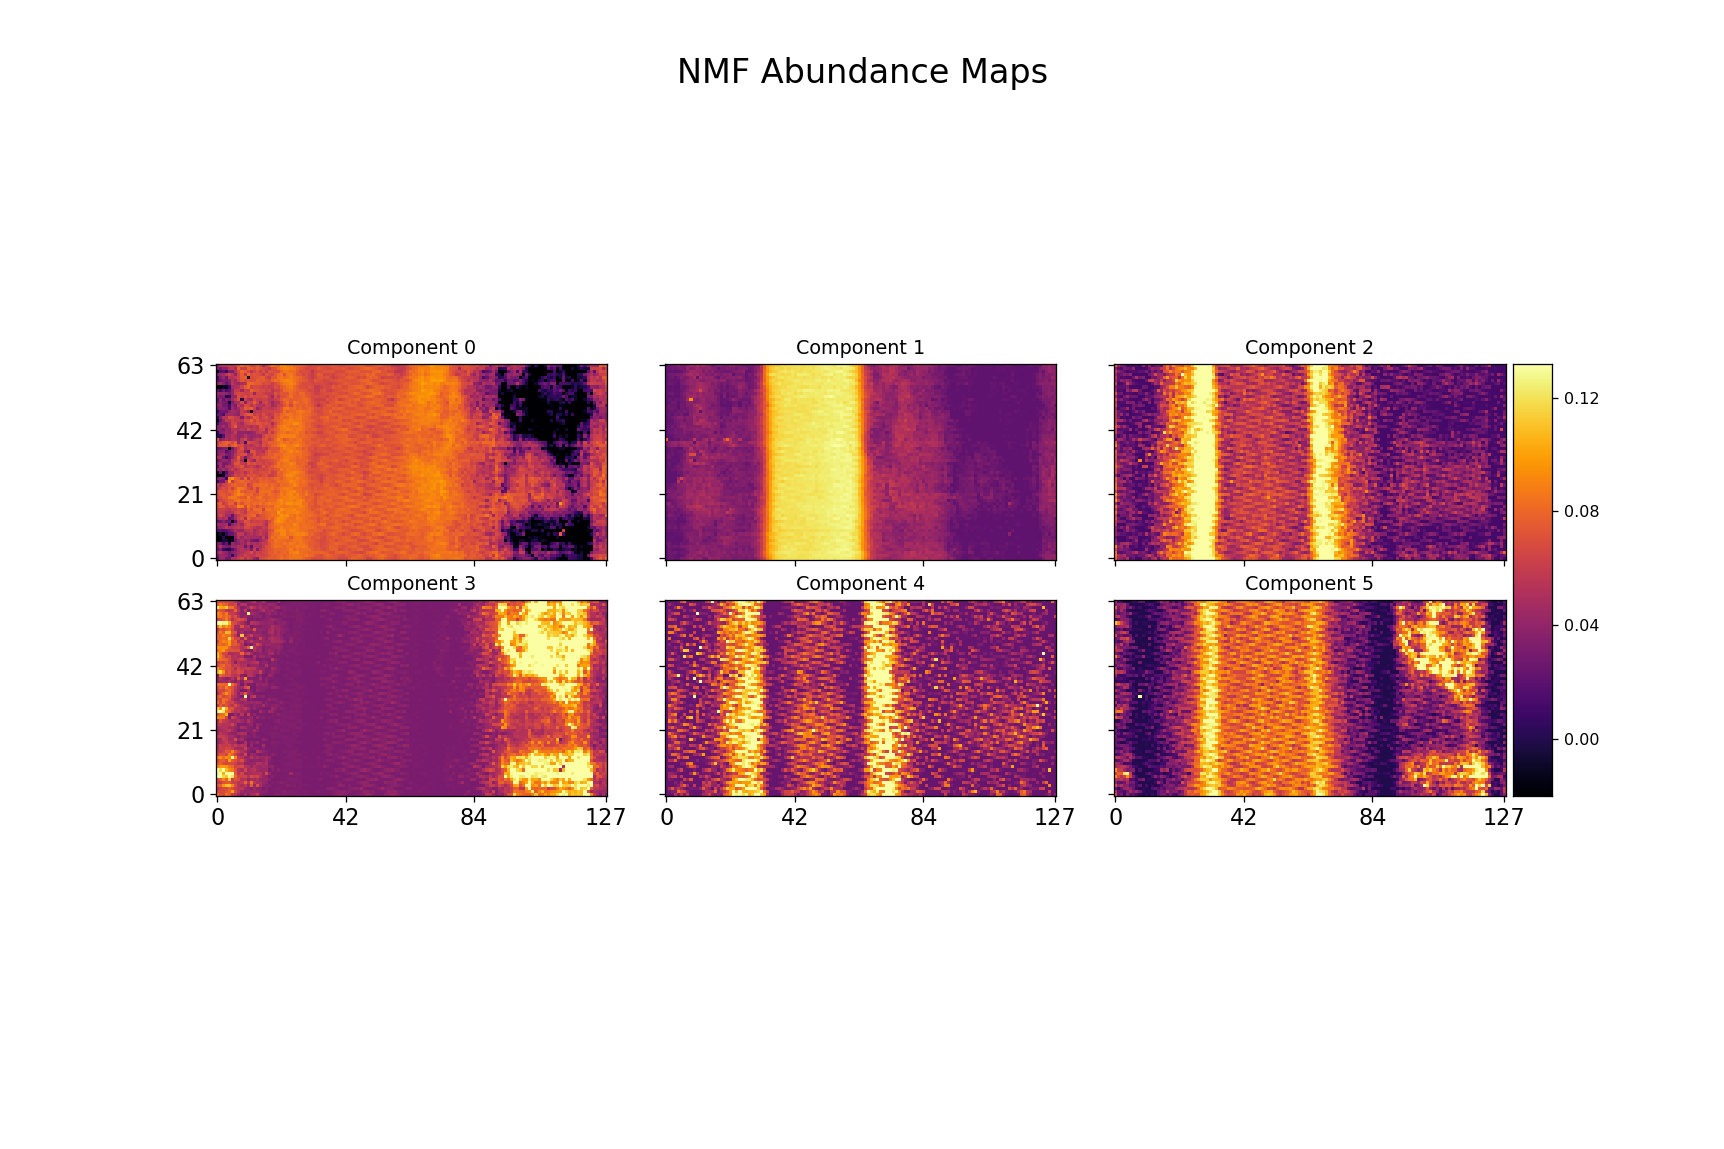

<IPython.core.display.Javascript object>


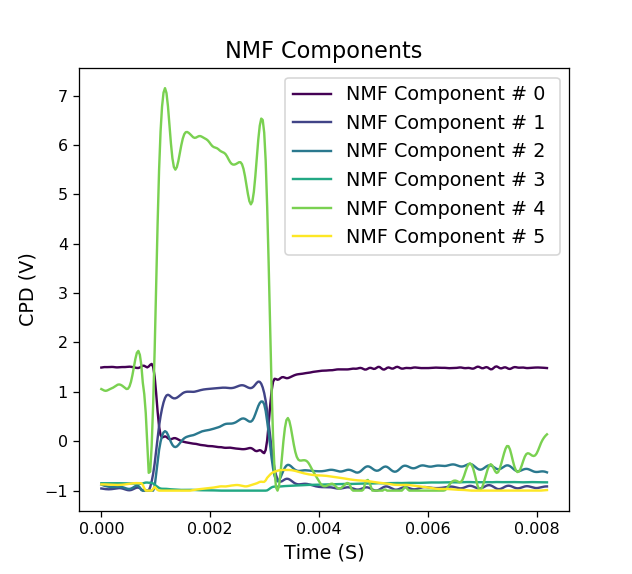

In [120]:

my_data = h5_CPD[:].reshape(num_rows*num_cols,-1)

from sklearn.decomposition import NMF

my_data = my_data+1


nmf = NMF(n_components=6, l1_ratio=0.2)

nmf.fit(my_data)

components = nmf.components_[:]
coeffs = nmf.fit_transform(my_data)

nmf_coeffs_fig = usid.plot_utils.plot_map_stack(coeffs[:].reshape(num_rows,num_cols,-1), num_comps=9, title='NMF Abundance Maps', reverse_dims=True,
                             color_bar_mode='single', cmap='inferno', title_yoffset=0.95)

# Visualize the components:
nmf_comp_fig, axis = plt.subplots(figsize=(5.5, 5))
usid.plot_utils.plot_line_family(axis, h5_spec_vals[:].ravel(), components, label_prefix='NMF Component #')
axis.set_xlabel(x_label, fontsize=12)
axis.set_ylabel(y_label, fontsize=12)
axis.set_title('NMF Components', fontsize=14)
axis.legend(bbox_to_anchor=[1.0, 1.0], fontsize=12)